In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import patsy
import sklearn.linear_model as linear
import random
from pprint import pprint
from IPython.display import HTML, display_html
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid")

# Spam Email Classification

Authors: Group 3:  Greg Carmean, Randall Hanna, Michael Hsien, Jeremy Kline, Jack Shu, William Stone

This report details the creation of a spam email classifier based on the following dataset: https://www.openintro.org/data/index.php?data=email. 

The data represents incoming emails for the first three months of 2012 for an email account.

The objective is to build a classifier that will filter out as much of the spam as possible while allowing non-spam emails through to the users inbox

# 1 ETL

The first step is to load in the data. The .csv file was downloaded in a .zip file from the openintro site and uploaded to an authors GitHub page so it could be reliably read into Colab.

In [2]:
emails = pd.read_csv("https://raw.githubusercontent.com/MeanMachine9918/spam_email_data/main/Email_Data.csv")


We'll look at the overall characteristics of the data to make sure it loaded correctly. First, let's get the basic data frame info:

In [3]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3921 entries, 0 to 3920
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   row           3921 non-null   int64  
 1   spam          3921 non-null   int64  
 2   to_multiple   3921 non-null   int64  
 3   from          3921 non-null   int64  
 4   cc            3921 non-null   int64  
 5   sent_email    3921 non-null   int64  
 6   time          3921 non-null   object 
 7   image         3921 non-null   int64  
 8   attach        3921 non-null   int64  
 9   dollar        3921 non-null   int64  
 10  winner        3921 non-null   object 
 11  inherit       3921 non-null   int64  
 12  viagra        3921 non-null   int64  
 13  password      3921 non-null   int64  
 14  num_char      3921 non-null   float64
 15  line_breaks   3921 non-null   int64  
 16  format        3921 non-null   int64  
 17  re_subj       3921 non-null   int64  
 18  exclaim_subj  3921 non-null 

There are a total of 3921 entries and 3921 observations for each variable, so there are no missing values which is good.

We look at the first few rows to see if there are any issues with the format of the data

In [4]:
emails.head()

,row,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
0,1,0,0,1,0,0,12/31/2011 22:16,0,0,0,...,0,0,11.370,202,1,0,0,0,0,big
1,2,0,0,1,0,0,12/31/2011 23:03,0,0,0,...,0,0,10.504,202,1,0,0,0,1,small
2,3,0,0,1,0,0,1/1/2012 1:09,0,0,0,...,0,0,13.256,255,1,0,0,0,48,small
3,4,0,0,1,0,0,1/1/2012 2:00,0,0,0,...,0,2,1.231,29,0,0,0,0,1,none
4,5,0,0,1,0,0,1/1/2012 2:04,0,0,0,...,0,2,1.091,25,0,0,0,0,1,none


Everything looks good so we can now begin exploring the dataset

#2 EDA

The EDA section will explore the dataset to understand what emails are contained in the dataset and trends across the emails that relate to their classification as spam. Each variable will be analyzed individually and then its relationship with spam will be examined. 

## 2.1 Single Varialbe EDA

This subsection will inspect each variable in the dataset individually.

### 2.1.1 spam

Definition: Spam is the target variable of this dataset. It is a binary classification determining whether or not the email is spam. 

In [5]:
emails["spam"].value_counts(normalize=True)

0    0.906401
1    0.093599
Name: spam, dtype: float64

Only a small portion of the dataset actually represents spam emails. 90.6% of the data is legitamate emails, and 9.4% is spam. Let's plot the values up as well.

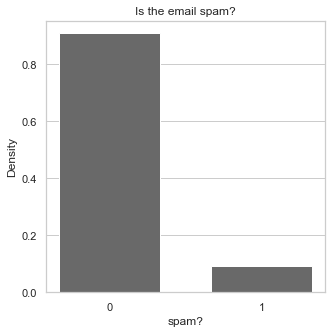

In [6]:
counts = emails["spam"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(5, 5))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Is the email spam?")
axes.set_xlabel("spam?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

### 2.1.2 to_multiple

The to_multiple is a categorical variable that tracks whether or not their are multiple recipients in the to field. A hallmark of spam is that is sent indiscriminantly to many people so items that have this are more likely to be spam. However, these email blast can be done without including everyones name in the to field adding uncertainity to this variables relationship to spam.

In [7]:
pd.DataFrame(emails["to_multiple"].value_counts(normalize = True).sort_index())

,to_multiple
0,0.841877
1,0.158123


Most of the data in the dataset includes multiple recipients. This does not make it an indicator of spam given the low incidence of spam in the dataset, however the lack of it may be a signal.

These probabilities can be visualized to get a better understanding of their relative proportions.

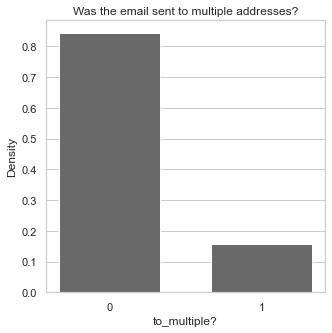

In [8]:
counts = emails["to_multiple"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(5, 5))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Was the email sent to multiple addresses?")
axes.set_xlabel("to_multiple?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

The emails not sent to other addresses is roughly 5 times larger than those that are.


### 2.1.3 from

The from indicator represents whether the from variable is listed as from anyone.

In [9]:
pd.DataFrame(emails["from"].value_counts(normalize = True).sort_index())

,from
0,0.000765
1,0.999235


The vast majority of emails in the dataset have the from tab filled in. Its worth looking at the raw numbers to see how many don't with that small a percentage.

Here are the raw numbers for the from tab


In [10]:
pd.DataFrame(emails["from"].value_counts().sort_index())

,from
0,3
1,3918


Only 3 emails in the entire dataset don't have an entry in the from tab. These entries should be tabbed for further review as possible outliers.

Here are the three entries not listed as from anyone


In [11]:
emails[emails["from"] == 0]

,row,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
153,154,1,0,0,0,0,1/4/2012 15:19,0,0,0,...,0,0,3.543,21,1,0,0,0,1,small
1008,1009,1,0,0,0,0,1/25/2012 13:20,0,0,2,...,0,0,1.296,37,0,0,0,0,0,big
1009,1010,1,0,0,0,0,1/25/2012 13:23,0,0,2,...,0,0,1.296,37,0,0,0,0,0,big


All of these 3 emails are classified as spam and do not otherwise stand out as outliers or misentered data. Therefore the entries will be kept and analyzed as part of the dataset.

### 2.1.4 cc

The cc variable is an integer numeric variable, and denotes how many people were cc'd on the email. It's possible that having a high number of people cc'd on the email could be a good indicator for spam.

In [12]:
emails["cc"].value_counts(normalize=False).sort_index()

0     3436
1      278
2       80
3       41
4       33
5        7
6        9
7        8
8        2
9        2
12       1
13       1
15       3
16       3
18       1
19       1
21       1
23       1
25       1
31       2
33       1
35       5
38       1
50       1
64       1
68       1
Name: cc, dtype: int64

Here we see that having no one cc'd is by far the most common instance, occuring 87.6% of the time. Having 1-4 people cc'd on the email also happens sometimes but scarcely. Numbers above this are rare and appear sporadically in the set. Let's plot them up.

In [13]:
emails["cc"].describe()

count    3921.000000
mean        0.404489
std         2.666424
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        68.000000
Name: cc, dtype: float64

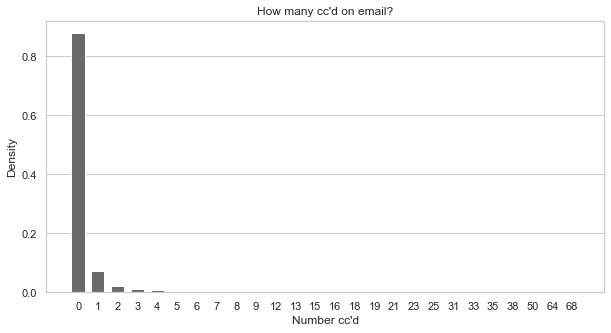

In [14]:
counts = emails["cc"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "How many cc'd on email?")
axes.set_xlabel("Number cc'd")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

The distribution on cc looks to be approximately exponential.

### 2.1.5 sent_email

sent_email is a binary categorical attribute, and determines if another email was received from the sender 30 days prior to the email in question. This is probably going to be a decent indicator of the email being spam.

In [15]:
emails["sent_email"].value_counts(normalize=True)

0    0.72201
1    0.27799
Name: sent_email, dtype: float64

Here we see that it is most often the case (72.2%) that they have received 0 other emails from the sender during that duration. That number seems pretty high from personal experience.

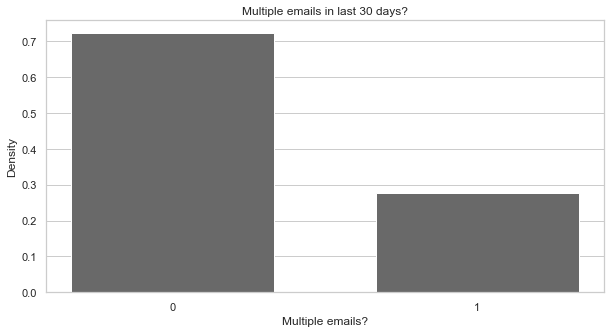

In [16]:
counts = emails["sent_email"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Multiple emails in last 30 days?")
axes.set_xlabel("Multiple emails?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

The proportion of accounts that have vs have not sent emails in the last 30 days is about 2:1.


### 2.1.6 time

Time tracks the exact time in datetime64 format that the email was received. While each time is unique, trends may be extracted from the day of the week or month and time of day the email was received to determine whether or not it is spam. 

For example:  If emails are coming in at 2AM, they are probably automated. 

In [17]:
pd.DataFrame(emails[ "time"].describe(datetime_is_numeric=True))

,time
count,3921
unique,3698
top,3/3/2012 14:40
freq,5


The description tells us that the distribution of emails is fairly evenly spread across time throughout this dataset. The dataset stretchs from december 31st 2011 to march 31 2012 with a mean and median around Feb 15th.

Unique date-times will not be a useful detector of what is and what is not spam as these time will never appear again. However, the date-time data can be segmented into useful information. The day of the week, the day of the month, and the time of the day are all cycles in the data that could be related to whether or not an email is spam. These categories will be extracted from the starting time variable, starting with the time of day. Time of day will be a numeric variable.


In [18]:
emails['timestamp'] = emails[ "time"]
for email in range(0,emails.shape[0]):
    emails.loc[email,'timestamp'] = pd.Timestamp(emails.loc[email,'time'])

Converting to a timestamp makes it easy to extract the different categories of interest.

First lets get the days of the week each of the emails are sent


In [19]:
emails['day_of_week'] = emails[ "time"]
for email in range(0,emails.shape[0]):
    emails.loc[email,'day_of_week'] = emails.loc[email,'timestamp'].dayofweek 
pd.DataFrame(emails[ "day_of_week"].describe())

,day_of_week
count,3921
unique,7
top,2
freq,742


The day of the week is a categorical variable from 1-7, where 1 represents Monday, 2 represents Tuesday and so on. The most emails were received on Tuesday

Lets look at the distribution of the days of the week when emails were received.


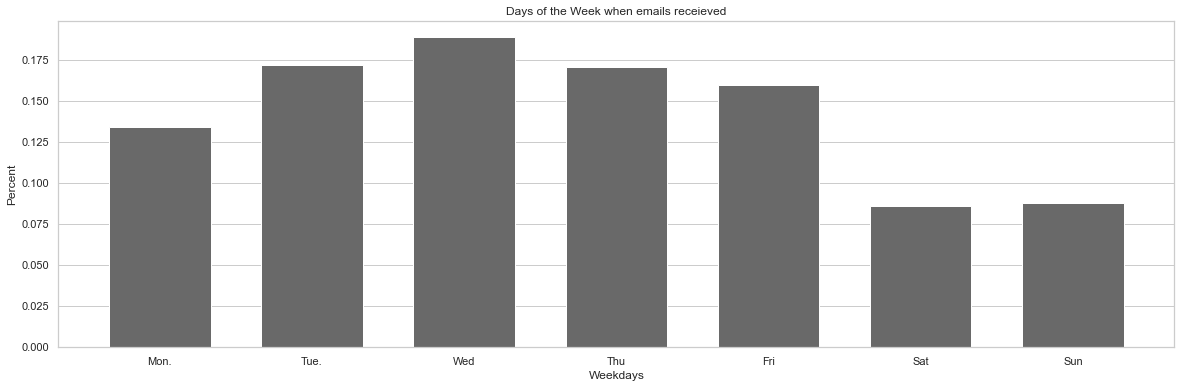

In [20]:
weekdays = emails["day_of_week"].value_counts(normalize=True).sort_index()
x = range( len(weekdays))
width = 1/1.5

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, weekdays, width, color="dimgray", align="center")
axes.set_xticks([0, 1,2,3,4,5,6])
axes.set_xticklabels(["Mon.","Tue.","Wed","Thu","Fri","Sat","Sun"])
axes.set_title( "Days of the Week when emails receieved")
axes.set_ylabel( "Percent")
axes.set_xlabel( "Weekdays")
axes.xaxis.grid(False)

There are a larger proportions of emails recieved during the work week than on weekend days. Emails peak in the middle of the workweek, which is likely due to the impact of work as well.

Another interesting property that can be extracted from time is at what hour an email arrives. While we have data down to the nanosecond, that is too noisy for the current problem, whether or not an email is spam. However, the hour an email arrives may shed contain some signal, as real people are likely to send emails during regular hours and automated spam arrives at all hours


In [21]:
emails['hour'] = emails[ "time"]
for email in range(0,emails.shape[0]):
    emails.loc[email,'hour'] = emails.loc[email,'timestamp'].hour 
pd.DataFrame(emails[ "hour"].describe())

,hour
count,3921
unique,24
top,8
freq,327


The most emails are received at the 8am hour, or the start of the workday. This tracks with most emails being related to work.

The visualization of the distribution of emails by hour is shown below


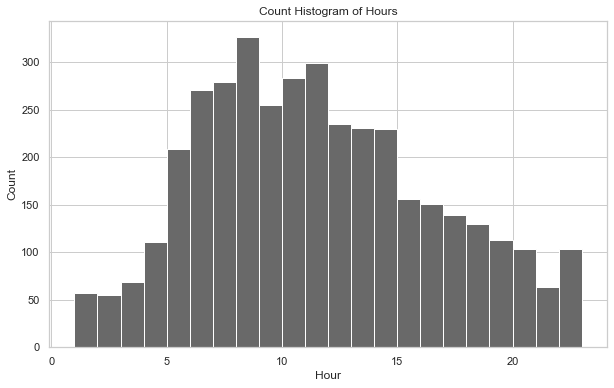

In [22]:
figure = plt.figure(figsize=(10, 6))

bins = [ i for i in range(1, 24, 1)]
axes = figure.add_subplot(1, 1, 1)
axes.hist( emails[ "hour"], bins = bins, color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Hour")
axes.set_title("Count Histogram of Hours")

plt.show()
plt.close()

### 2.1.7 image

The image attribute is a discrete numeric variable that denotes how many images are contained in the email. Most spam that we've encountered contains some kind of visual flare, so we would expect this to be a good indicator.

In [23]:
emails["image"].value_counts(normalize=True)

0     0.971946
1     0.019383
2     0.004336
3     0.002805
5     0.000510
4     0.000510
9     0.000255
20    0.000255
Name: image, dtype: float64

So we see overwelmingly that most emails contain no images (97.2%), but there are instances of emails containing 9 and even 20 images!

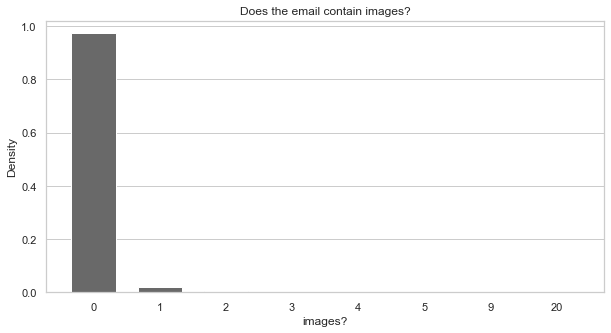

In [24]:
counts = emails["image"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Does the email contain images?")
axes.set_xlabel("images?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

When dealing with this variable we might consider creating a new attribute has_images which is just a binary categorical.

In [25]:
emails["has_image"] = emails["image"].apply(lambda x: 1 if x > 0 else 0)

### 2.1.8 attach

This variable describes the number of attached files on the email. I'm not sure if we should expect spam emails to have attachment or not. If were were looking for viruses then we would, but spam doesn't necesarrily have them


In [26]:
pd.DataFrame(emails[ "attach"].describe())

,attach
count,3921.000000
mean,0.132874
std,0.718518
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,21.000000


So it looks like most of our values here are zero. Considering the max is 21 but the average is close to zero and the first, second and third quartile are all 0. A scatterplot here would not be a good call because of the zero values in the quartiles. So to see the distribution of the data we will create a bar chart with counts about the y axis and values about the x axis.

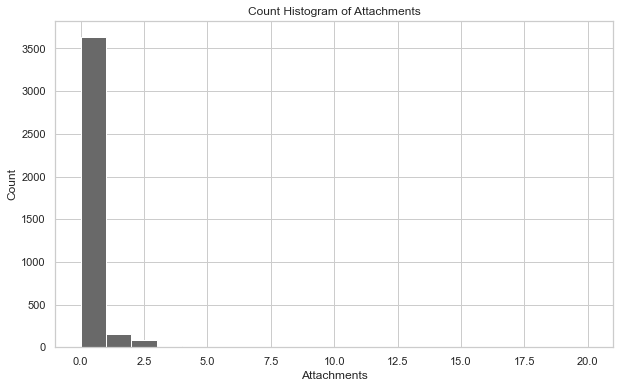

In [27]:
figure = plt.figure(figsize=(10, 6))

bins = [ i for i in range(0, 21, 1)]
axes = figure.add_subplot(1, 1, 1)
axes.hist( emails["attach"], bins = bins, color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "Attachments")
axes.set_title("Count Histogram of Attachments")

plt.show()
plt.close()



So most of our values are definitly 0 and that is easily seen above. While it looks like there is no data for values 3,4,5,6,7,8,9,10,20,21 we know that is not the case the number of instances is just so small it looks like 0 on this scale

So it looks like most of our population of emails contain no attachments.


### 2.1.9 dollar

This variable describes the number of times a dollar sign or the word "dollar" appeared in the email. We can expect that spam emails may contain dollar amounts, but at the same time it isn't out of the ordinary for normal emails to also have dollar signs.

In [28]:
pd.DataFrame(emails['dollar'].describe())

,dollar
count,3921.000000
mean,1.467228
std,5.022298
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,64.000000


Once again it looks as though the data for this feature is also heavily weighted at zero. If we visualize it though, we should see higher counts of instances greater than 1 than we saw in the attach column since our mean is close to 1.5


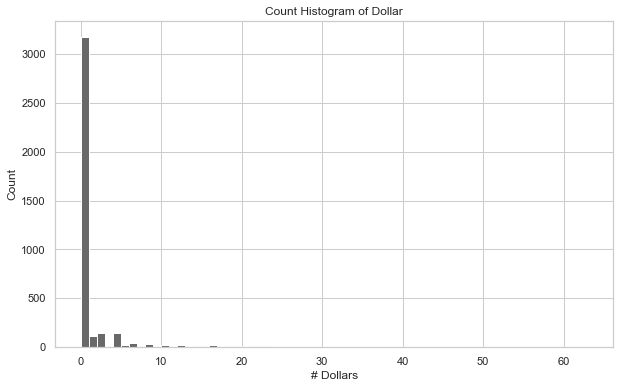

In [29]:
figure = plt.figure(figsize=(10, 6))
mx = int(emails["dollar"].max())


bins = [ i for i in range(0, mx, 1)]
axes = figure.add_subplot(1, 1, 1)
axes.hist( emails["dollar"], bins = bins, color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "# Dollars")
axes.set_title("Count Histogram of Dollar")

plt.show()
plt.close()

Just like before we are heavily weighted at 0 meaning most of the emails that were collected did not contian the word dollar or the symbol $.

However, we do see a greater number of 1+ than we saw with our previous feature. It will be interesting to see whether or not this feature correlates to spam. One may think so since if the email contains dollar it could be along the lines of "Win this dollar amount" or "Pay this much for..." which could be emails highly associated with spam emails.


### 2.1.10 winner

This variable indicates whether "winner" appeared in the email. Unlike the previous variables this does not check the number of times it appeared.

In [30]:
pd.DataFrame(emails['winner'].value_counts())

,winner
no,3857
yes,64


In [31]:
pd.DataFrame(emails['winner'].value_counts(normalize=True))

,winner
no,0.983678
yes,0.016322


The vast majority of emails do not contain the word winner. This is probably a good choice to look at with spam to see if the emails that contain winner are linked to spam

### 2.1.11 inherit

This variable describes the number of times "inherit" (or an extension, such as "inheritance") appeared in the email.

In [32]:
pd.DataFrame(emails['inherit'].describe())

,inherit
count,3921.000000
mean,0.038001
std,0.267899
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


In [33]:
pd.DataFrame(emails['inherit'].value_counts())

,inherit
0,3793
1,122
2,3
6,2
9,1


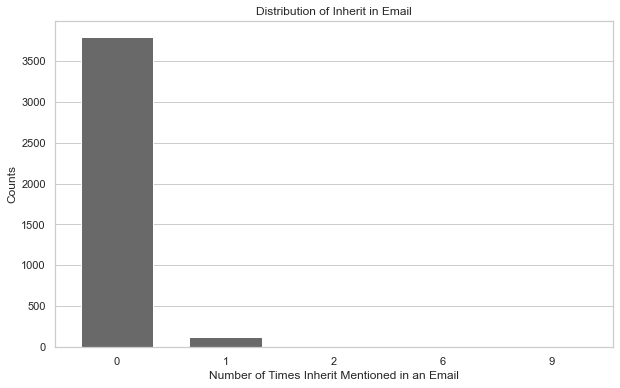

In [34]:
inherit_counts = emails["inherit"].value_counts()
x = range( len( inherit_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, inherit_counts, width, color="dimgray", align="center")

axes.set_xticks(x)
axes.set_xticklabels(np.sort(inherit_counts.axes[0]))
axes.set_title( "Distribution of Inherit in Email")
axes.set_ylabel( "Counts")
axes.set_xlabel("Number of Times Inherit Mentioned in an Email")
axes.xaxis.grid(False)

plt.show()
plt.close()

Mostly zero, as we thought. This isn't a very interesting feature unless most of our zeros are not spam and 1, 2, 6, or 9 have a higher percentage of spam. 

### 2.1.12 viagra

This variable describes the number of times "viagra" appeared in the email

In [35]:
pd.DataFrame(emails['viagra'].value_counts())

,viagra
0,3920
8,1


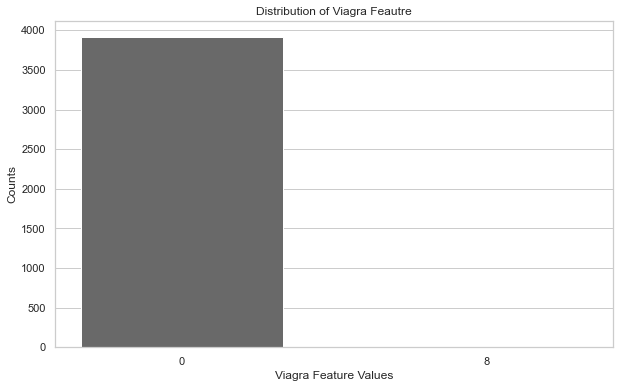

In [36]:
viagra_counts = emails["viagra"].value_counts()
x = range( len( viagra_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, viagra_counts, width, color="dimgray", align="center")

axes.set_xticks(x)
axes.set_xticklabels(np.sort(viagra_counts.axes[0]))
axes.set_title( "Distribution of Viagra Feautre")
axes.set_ylabel( "Counts")
axes.set_xlabel("Viagra Feature Values")
axes.xaxis.grid(False)

plt.show()
plt.close()

Literally only one email has the word viagra in it. While emails with the word viagra are most likely spam, training a model on this will be challenging this this limited data

### 2.1.13 password

This variable describes the number of times "password" appeared in the email. Like with inheritance, we believe that this may be linked with scam emails.

In [37]:
pd.DataFrame(emails['password'].describe())

,password
count,3921.000000
mean,0.108136
std,0.959931
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,28.000000


In [38]:
pd.DataFrame(emails['password'].value_counts(normalize = True))

,password
0,0.971436
2,0.009946
4,0.005866
1,0.005611
3,0.002040
5,0.001275
8,0.001275
6,0.000765
11,0.000510
22,0.000510


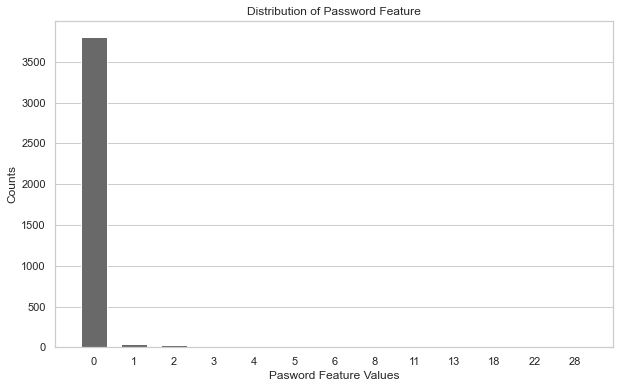

In [39]:
pword_counts = emails["password"].value_counts()
x = range( len( pword_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, pword_counts, width, color="dimgray", align="center")

axes.set_xticks(x)
axes.set_xticklabels(np.sort(pword_counts.axes[0]))
axes.set_title( "Distribution of Password Feature")
axes.set_ylabel( "Counts")
axes.set_xlabel("Pasword Feature Values")
axes.xaxis.grid(False)

plt.show()
plt.close()

97% of the emails did not include the word passwrod. However, it is worth exploring whether as the number of password mentions grows the prevelance of spam increases. How many normal emails would mention password 28 times?

### 2.1.14 num_char

This variable describes the number of characters in the email, in thousands. 

In [40]:
pd.DataFrame(emails['num_char'].describe())

,num_char
count,3921.000000
mean,10.706586
std,14.645786
min,0.001000
25%,1.459000
50%,5.856000
75%,14.084000
max,190.087000


The average email in the dataset has 10706 lines. The standard deviation of 14000 lines indicates there is a good deal of variance. The max of 190,000 and 75% percentile of 14,000 indicate there are some outliers skewing the total distribution. 

An interesting line of inquiry is whether or not there are emails with the same number of characters. That may indicate a pattern which points to spam. 

In [41]:
pd.DataFrame(emails['num_char'].value_counts())

,num_char
0.459,12
0.537,10
0.341,10
1.222,6
10.366,6
...,...
30.363,1
3.314,1
11.071,1
0.180,1


While there are some emails which have a common number of characters, the vast majority of the emails in the dataset have a unique character count

The distribution of the character count can be visualized with a histogram

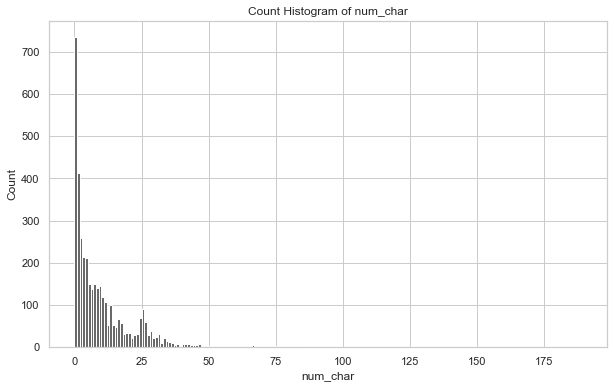

In [42]:
figure = plt.figure(figsize=(10, 6))

mx = int(emails["num_char"].max())
mn = int(emails["num_char"].min())


bins = [ i for i in range(mn, mx, 1)]
axes = figure.add_subplot(1, 1, 1)
axes.hist( emails["num_char"], bins = bins, color="DimGray")
axes.set_ylabel( "Count")
axes.set_xlabel( "num_char")
axes.set_title("Count Histogram of num_char")

plt.show()
plt.close()

The histogram shows that the num_char variable appears exponentially distributed. This could help lead to a useful variable transformation during the modeling process.

### 2.1.15 line_breaks

The line_breaks variable refers to the number of line breaks in the email. This count does not include text wrapping. The hypothesis is that the values should not be negative and relatively small, no more than a couple hundred. 

In [43]:
emails["line_breaks"].describe()

count    3921.000000
mean      230.658505
std       319.304959
min         1.000000
25%        34.000000
50%       119.000000
75%       298.000000
max      4022.000000
Name: line_breaks, dtype: float64

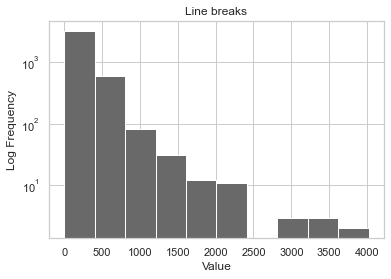

In [44]:
fig = plt.figure()
axes = fig.add_subplot()
axes.hist(emails['line_breaks'], color="dimgray",log=True)
axes.set_xlabel('Value')
axes.set_ylabel('Log Frequency')
axes.set_title('Line breaks')

plt.show()

Line breaks appears exponentially distributed. The numbers seem inflated to me, even the spam emails I get don't have 3-4k lines in them. However, the exponential fits well so I suspect these are real data points. 

### 2.1.16 format

The format variable indicates whether the email was written using HTML. For example, emails that may have included bolding or active links are included in this category.

Since this is a binary variable we can just create a table to count the numer of emails with format and those without format.

In [45]:
pd.DataFrame(emails['format'].value_counts())

,format
1,2726
0,1195


In [46]:
pd.DataFrame(emails['format'].value_counts(normalize=True))

,format
1,0.695231
0,0.304769


Almost 70% of the emails are formatted in HTML. The pairwise EDA should shed more light on whether or not this variable is significant.

### 2.1.17 re_subj

The re_subj variable tracks whether the subject started with "Re:", "RE:", "re:", or "rE:".

This variable is of interest because "Re" or similar it usually indicates a reply to the original message, which would tend to not be spam.  Let's check by constructing a table:

In [47]:
pd.DataFrame(emails['re_subj'].value_counts())

,re_subj
0,2896
1,1025


In [48]:
pd.DataFrame(emails['re_subj'].value_counts(normalize = True))

,re_subj
0,0.738587
1,0.261413


Only 26% of the data is a reply with this phrase in their subject line. It may yet be a significant indicator for this subset of the data. 

### 2.1.18 exclaim_subj

The exclaim_subj variable tracks whether there was an exclamation point in the subject. An example spam subject line could read:

"Click on this now!! To save XYZ dollars on the top deals!!!"
Therefore, the existance of exclaimation marks may spam? In which case this should follow the spam messages trend (e.g. most emails were not spam, so most of the 'exclaim_subj' should not have exclaimation marks). Let's check it:

In [49]:
pd.DataFrame(emails['exclaim_subj'].value_counts())

,exclaim_subj
0,3606
1,315


In [50]:
pd.DataFrame(emails['exclaim_subj'].value_counts(normalize=True))

,exclaim_subj
0,0.919663
1,0.080337


Indeed! This seems to have almost identical distribution to the spam tag at 92% no exclamation and 8% with exclamation (not spam tag = 91%, spam = 9%). This could be a coincidence but is worth investigating with a pairwise comparison.

### 2.1.19 urgent_subj

The urgent_subj variable tracks whether the word "urgent" was in the email subject.

We think this would have high corelation to spam as well, as it attempts to get people to click on the link or fall for the scam in a hurry. Let's see how often urgent appears in the subject of these emails.

In [51]:
pd.DataFrame(emails['urgent_subj'].value_counts())

,urgent_subj
0,3914
1,7


In [52]:
pd.DataFrame(emails['urgent_subj'].value_counts(normalize=True))

,urgent_subj
0,0.998215
1,0.001785


Only 7 emails have urgent in the subject line. Maybe those emails were indeed urgent after all and people reserve the "urgent" keywords for truly urgent matters. Even if the pairwise comparison reveals a relationship to spam, it may be difficult to train a model with so few examples.

**NOTE regarding: format, re_subj, exclaim_subj, urgent_subj**
    
Based on the variable descriptions these variables are all binary. Hence, there was not much we can do here but print out their variable descriptions and frequencies.

Bearing in mind that only 9% of emails are labeled spam we probably want to focus on the lower frequency binary variables like exclaim_subj and urgent_subj as they have a lower likelihood of giving us false positives.

### 2.1.20 exclaim_mess

This variable is the count of exclamation points in the message. It should be a positive integers and relatively small. We'd expect most email threads to have < 20 exclamation points. 

In [53]:
emails['exclaim_mess'].describe()

count    3921.000000
mean        6.584290
std        51.479871
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max      1236.000000
Name: exclaim_mess, dtype: float64

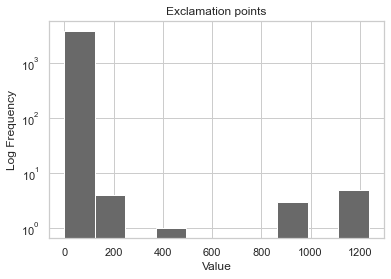

In [54]:
fig = plt.figure()
axes = fig.add_subplot()
axes.hist(emails['exclaim_mess'], color="dimgray",log=True)
axes.set_xlabel('Value')
axes.set_ylabel('Log Frequency')
axes.set_title('Exclamation points')

plt.show()

As a count varible this follows an exponential distribution with the vast majority less than 100. the 75% quantile is only 4 which is very reasonable. There are a small number of high outliers that are very suspicous (400 or more exclamation points!). 

### 2.1.21 number

The number variable is a factor variable whose three categories are; whether there was no number, a small number (under 1 million), or a big number.

The first step is to look at the counts for each of the factors:

In [55]:
pd.DataFrame(emails['number'].value_counts())

,number
small,2827
none,549
big,545


In [56]:
pd.DataFrame(emails['number'].value_counts(normalize = True))

,number
small,0.720990
none,0.140015
big,0.138995


Yes as expected roughly 86% of the entries are either small or none. This leaves ~14% containting large numbers. This is relatively close to frequency of spam emails, 9%, and should be looked at further. 

## 2.2 Pairwise EDA

Now that each variable has been examined individually, comparison to the spam classification and other relevant pairwise comparisons can be made. Due to the largely binary nature of the data, there are not alot of opportunities for other pairwise comparisons.

### 2.2.1 spam vs to_multiple

The first comparison to make to the target variable, spam, is to_multiple. The prediction is if a sendor is sending out mass emails, there may be a good chance that the emails are spam. Both are categorical variables so their joint pdf can be analyzed

In [57]:
result = pd.crosstab( emails[ "to_multiple"], emails[ "spam"]).apply(lambda r: r/len(emails), axis=1)
print( result)

spam                0         1
to_multiple                    
0            0.751339  0.090538
1            0.155062  0.003060


ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (8).

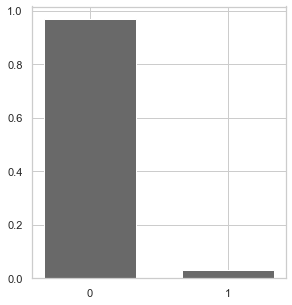

In [58]:
counts1 = emails[emails["spam"]==1]["to_multiple"].value_counts(normalize=True).sort_index()
counts2 = emails[emails["spam"]==0]["to_multiple"].value_counts(normalize=True).sort_index()
x = range( len(counts1))
width = 1/1.5

figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, counts1, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "spam")
axes.set_xlabel("to_multiple?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

axes = figure.add_subplot(1, 2, 2)
axes.bar(x, counts2, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "not spam")
axes.set_xlabel("to_multiple?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

The trend differs from the original hypothesis. The global percentage of spam in the dataset is 9%, so the fact that almost none of the to_multiple emails have spam means it has no relationship to predicting whether an email is spam. However we notice that very few of the spam messages are sent to multiple people which is interesting.

### 2.2.2 spam vs from

This comparison tracks whether the from field is filled in and whether it is spam. Since there are only 3 examples where from is not filled in, there are questions as to whether it should be considered as a predictor. However, there is a chance the small samples could show a correlation to an email being spam

In [ ]:
result = pd.crosstab( emails[ "from"], emails[ "spam"]).apply(lambda r: r/len(emails), axis=1)
print( result)

The fact that no emails without a from line are not spam is notable, but the small number of samples makes this challenging to use in a model. 

### 2.2.3 spam vs cc

cc vs spam tracks the numbers of emails cc'ed in the email against whether or not the emails are spam. The default hypothesis is that emails with more cc's should be more likely then the global average to be spam since that is one way to get a wide distribution.

In [ ]:
spamGroup = emails.groupby("spam")
ccBySpam = spamGroup["cc"].describe()
print(ccBySpam)
print("IQR  =", ccBySpam.loc[:,"75%"]- ccBySpam.loc[:,"25%"])

The means for the spam and not spam number of cc's are similar, which provisionally disproves the hypothesis. The standard deviation is higher on the spam emails, however they're are also an order of magnitude fewer of those so more variance makes sense. 

To make sure that we cover all our bases lets dig a little deeper into how cc relates to spam

In [ ]:
bins = [ i for i in range(0, 68, 1)]
figure = plt.figure(figsize=(20, 6))
figure.suptitle("Distributions of cc's by Spam Classification")
spams = pd.unique(emails["spam"].values)
for i, x in enumerate(spams):
    axes = figure.add_subplot(1, 2, i + 1)
    subdata = spamGroup["cc"].get_group(x).values
    axes.hist(subdata, bins=bins, alpha=0.75, color="DimGray",density = True)
    axes.set_title(x)
    axes.set_ylim((0,1))
plt.show()
plt.close()

There is a wider variety of cc's without spam then there are with spam at all levels. While that is to be expected when the samples are so lopsided, it presents no evidence that cc's will be useful helpful identifying spam. 

The scale of the previous distribution is difficult to draw conclusions from. Lets look at a boxplot to confirm the original conclusion from the histogram

In [ ]:
figure = plt.figure(figsize=(10, 5))

x1 = emails[emails["spam"]==1]["cc"]
x2 = emails[emails["spam"]==0]["cc"]

axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(x1, labels=['spam'], showfliers=True, patch_artist=True, zorder=1)
axes.set_title("cc vs. spam")
axes.set_ylabel("cc")

axes = figure.add_subplot(1, 2, 2)
patch = axes.boxplot(x2, labels=['not spam'], showfliers=True, patch_artist=True, zorder=1)
axes.set_title("cc vs. not spam")
axes.set_ylabel("cc")


plt.show()
plt.close()

There doesn't seem to be any clear trends from the boxplot either.The fact that most most of the emails in the dataset don't have any cc's is distorting the plotting. A new binary categorical variable called `is_cc` will allow this to be looked at.

In [ ]:
emails["is_cc"] = emails["cc"].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
counts1 = emails[emails["spam"]==1]["is_cc"].value_counts(normalize=True).sort_index()
counts2 = emails[emails["spam"]==0]["is_cc"].value_counts(normalize=True).sort_index()
x = range( len(counts1))
width = 1/1.5

figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, counts1, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "spam")
axes.set_xlabel("is_cc?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

axes = figure.add_subplot(1, 2, 2)
axes.bar(x, counts2, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "not spam")
axes.set_xlabel("is_cc?")
axes.set_ylabel( "Density")
axes.xaxis.grid(False)

plt.show()
plt.close()

So it looks like the suspicion is confirmed. Most of the time no one is cc'd on an email, and the relative frequency between spam and not spam doesn't look very significant. This attribute probably isn't going to help the model very much.

### 2.2.4 spam vs sent_email

the sent_email variable refers to whether or not the account that sent the email had sent another email in the last 30-days. The hypothesis for this comparison is that frequent senders may be more likely to be spammers.

In [ ]:
result = pd.crosstab( emails[ "sent_email"], emails[ "spam"]).apply(lambda r: r/len(emails), axis=1)
print( result)

In [ ]:
counts1 = emails[emails["spam"]==1]["sent_email"].value_counts(normalize=True).sort_index()
counts2 = emails[emails["spam"]==0]["sent_email"].value_counts(normalize=True).sort_index()
x1 = range( len(counts1))
x2 = range( len(counts2))
width = 1/1.5

figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x1, counts1, width, color="dimgray", align="center")
axes.set_xticks(x1)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "spam")
axes.set_xlabel("sent_email?")
axes.set_ylabel( "Density")


axes = figure.add_subplot(1, 2, 2)
axes.bar(x2, counts2, width, color="dimgray", align="center")
axes.set_xticks(x2)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "not spam")
axes.set_xlabel("sent_email?")
axes.set_ylabel( "Density")

plt.show()

plt.close()

No emails that have sent another email in 30 days were used to send spam. This is an important finding, as emails that send frequent emails did not send spam, likely as spammers ditch addressed to try and beat spam filters. This is good information and will probabily contribute to the model

### 2.2.5 spam vs time

The day of week an email is sent may relate to whether it is spam. The hypothesis is that the weekend days should correlate to higher spam as workday days contain more work.

In [ ]:
result = pd.crosstab( emails[ "day_of_week"], emails[ "spam"]).apply(lambda r: r/len(emails), axis=1)
print( result)

Without other context, it appears that Tuesday (1), and Friday (4) have the most spam. For the spam to be evenly distributed, there would be 0.01337% chance an email is spam on that day. Therefore, Tuesday, Wendesday and Friday have the highest chances. However, these chances do not greatly exceed the default hypothesis. The weekend hypothesis is not substantiated by the data. 

The hour an email is recieved may also relate to whether or not it is spam. Pandas treats this as categorical so we will look at the joint probabilities for insight.

In [ ]:
result = pd.crosstab( emails[ "hour"], emails[ "spam"]).apply(lambda r: r/len(emails), axis=1)
print( result)

With so many categorical variables, it may help to visualize the whole matrix as a heatmap.

In [ ]:
sns.heatmap( result,cmap="Blues")

What stands out initially is how many emails are received during the workday. Additionally there appears to be an up-tick in spam emails recieved in the afternoon/evening hours.

Another way to visualize the relationship is with a histogram of the hour when the spam is received and when the non spam emails are received.

In [ ]:
counts1 = emails[emails["spam"]==1]["hour"].value_counts(normalize=True).sort_index()
counts2 = emails[emails["spam"]==0]["hour"].value_counts(normalize=True).sort_index()
x1 = range( len( counts1))
x2 = range( len( counts2))
width = 1/1.5

figure = plt.figure(figsize=(14, 5))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x1, counts1, width, color="dimgray", align="center")
axes.set_xticks(x1)
axes.set_xticklabels(counts1.axes[0])
axes.set_title( "spam")
axes.set_xlabel("Hour")
axes.set_ylabel( "Density")

axes = figure.add_subplot(1, 2, 2)
axes.bar(x2, counts2, width, color="dimgray", align="center")
axes.set_xticks(x2)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "not spam")
axes.set_xlabel("Hour")
axes.set_ylabel( "Density")


plt.show()
plt.close()

The histogram confirms that there is a difference in the distribution of spam and not spam emails by hour received. The not spam distribution looks approximately normal, centered around peak business hours. In contrast, spam looks equally likely to get sent at any time of day.

### 2.2.6 spam vs image

image vs spam compares the number of images attached to emails to see whether that is a predictor of spam. The default hypothesis here is that spam would be more likely to have an image attached, that would need to be downloaded along with some malware rider.

In [ ]:
imageBySpam = spamGroup["image"].describe()
print(imageBySpam)
print("IQR  =", imageBySpam.loc[:,"75%"]- imageBySpam.loc[:,"25%"])

The standard deviation of the not spam images makes it difficult to come to conclusions just based on the statistics.

The distributions may shed some more light on the relationship/

In [ ]:
figure = plt.figure(figsize=(10, 5))

x1 = emails[emails["spam"]==1]["image"]
x2 = emails[emails["spam"]==0]["image"]

axes = figure.add_subplot(1, 2, 1)
patch = axes.boxplot(x1, labels=['spam'], showfliers=True, patch_artist=True, zorder=1)
axes.set_title("spam")
axes.set_ylabel("image")

axes = figure.add_subplot(1, 2, 2)
patch = axes.boxplot(x2, labels=['not spam'], showfliers=True, patch_artist=True, zorder=1)
axes.set_title("not spam")
axes.set_ylabel("image")


plt.show()
plt.close()

It looks like emails that are spam contain *at most* one picture. This is good information to have as we can apply that threshold to the model. Unfortunately emails that do contain images seem to be the minority.

### 2.2.7 spam vs attach


This variable describes the number of attached files on the email. We are unsure if it would be expected for spam emails to have attachment or not

In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(emails.attach, emails.spam, marker="o", color="darkslategray")

axes.set_ylabel("SPAM")
axes.set_xlabel("Number of Attachments (ATTACH)")
axes.set_title("Scatter Plot of SPAM vs. ATTACH")

plt.show()
plt.close()

The scatter plot does not reveal much about the relationship. A look at the spam and not spam attachment distributions in small multiples may provide a clearer view of any differences.

In [ ]:
grouped = emails.groupby("spam")

figure = plt.figure(figsize=(20, 6))

bins = [ i for i in range(0, 21, 1)]


axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["attach"].get_group(0),bins=bins,color="dimgray",density=True)
axes.set_title("Not Spam attachment distribution")
axes.set_xlabel("Attatchments")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["attach"].get_group(1),bins=bins,color="dimgray",density=True)
axes.set_title("Spam attachment distribution")
axes.set_xlabel("Attatchments")

plt.show()
plt.close()

The distributions show most of the spam emails happen with zero attachments. However most all of our not spam emails also have zero attachments. Therefore it does not look like attachments is a very good indicator of whether or not an email is spam.

### 2.2.8 spam vs dollar

This variable describes the number of times a dollar sign or the word "dollar" appeared in the email. It can be expected that spam emails may contain dollar amounts, but at the same time it isn't out of the ordinary for normal emails to also have dollar signs.

In [ ]:
grouped_d = grouped["dollar"].describe()
print(grouped_d)


In [ ]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( emails.dollar, emails.spam, marker="o", color="dimgray")

axes.set_ylabel("SPAM")
axes.set_xlabel("Number of Times Dollar or $ Mentioned in Email")
axes.set_title("Scatter Plot of SPAM vs. DOLLAR")

plt.show()
plt.close()

This chart doesn't really provide us with any clarifying information. What we can do is look at a histogram of the data to expose the distribution of each data

In [ ]:
grouped = emails.groupby("spam")

figure = plt.figure(figsize=(20, 6))

bins = [ i for i in range(0, 64, 1)]


axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["dollar"].get_group(0),bins=bins,color="dimgray",density=True)
axes.set_title("Not Spam $ distribution")
axes.set_xlabel("$")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["dollar"].get_group(1),bins=bins,color="dimgray",density=True)
axes.set_title("Spam $ distribution")
axes.set_xlabel("$")

plt.show()
plt.close()

It appears that spam emails and non spam emails have very similar distributions for the number of times the word dollar is mentioned. This makes it a poor indicator for whether or not an email is spam.

### 2.2.9 spam vs winner

In order to compare the categorical variable winner to Spam, we can look at counts and use cross tabulation.

In [ ]:
spam = emails['spam']==1
notspam = emails['spam']==0
spam_yes = emails[spam]
spam_no = emails[notspam]

spam_winner_counts = spam_yes["winner"].value_counts()
not_spam_winner_counts = spam_no["winner"].value_counts()
x = range( len( spam_winner_counts))
x2 = range(len(not_spam_winner_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, spam_winner_counts, width, color="dimgray", align="center" )
axes.set_xticks(x)
axes.set_xticklabels(np.sort(spam_winner_counts.axes[0]))
axes.set_title( "Distribution of Winner - SPAM")
axes.set_ylabel( "Counts")
axes.set_xlabel("Winner")
axes.xaxis.grid(False)

axes = figure.add_subplot(1,2,2)
axes.bar(x2, not_spam_winner_counts, width, color="dimgray", align="center" )
axes.set_xticks(x2)
axes.set_xticklabels(np.sort(not_spam_winner_counts.axes[0]))
axes.set_title( "Distribution of Winner - Not SPAM")
axes.set_ylabel( "Counts")
axes.set_xlabel("Winner")
axes.xaxis.grid(False)

plt.show()
plt.close()

In [ ]:
pd.crosstab(emails["winner"],emails["spam"])

We can see that while not all emails with the word winner is spam, it seems to be more frequent than emails without the word winner. Lets check the relative frequencies as well.

In [ ]:
result = pd.crosstab( emails["winner"],emails["spam"]).apply(lambda r: r/r.sum(), axis=1)
print( result)

From our sample we see that 31% of the emails with the word winner are spam emails, compared to the 9% of emails without the word winner. This makes winner variable a useful feature for the model.

### 2.2.10 spam vs inherit

This variable describes the number of times "inherit" (or an extension, such as "inheritance") appeared in the email.

In [ ]:
grouped_i = grouped["inherit"].describe()
print(grouped_i)

In [ ]:
grouped = emails.groupby("spam")

figure = plt.figure(figsize=(20, 6))

bins = [ i for i in range(0, 9, 1)]


axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["inherit"].get_group(0),bins=bins,color="dimgray",density=True)
axes.set_title("Not Spam inherit distribution")
axes.set_xlabel("inherit")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["inherit"].get_group(1),bins=bins,color="dimgray",density=True)
axes.set_title("Spam inherit distribution")
axes.set_xlabel("inherit")

plt.show()
plt.close()

Once again the number of "inherit" in the document is similar for both spam emails and non spam emails making it unuseful in classifying spam.

### 2.2.11 spam vs viagra

From the single variable analysis of viagra we know there is only one email in the dataset with a positive value for viagra. That datapoint is shown below.

In [ ]:
emails[emails["viagra"] > 0]

In [ ]:
spam_viag_counts = spam_yes["viagra"].value_counts(normalize=True)
not_spam_viag_counts = spam_no["viagra"].value_counts(normalize=True)
x = range( len( spam_viag_counts))
x2 = range(len(not_spam_viag_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, spam_viag_counts, width, color="dimgray", align="center" )
axes.set_xticks(x)
axes.set_xticklabels(np.sort(spam_viag_counts.axes[0]))
axes.set_title( "Distribution of Viagra - SPAM")
axes.set_ylabel( "Counts")
axes.set_xlabel("Viagra")
axes.xaxis.grid(False)

axes = figure.add_subplot(1,2,2)
axes.bar(x2, not_spam_viag_counts, width, color="dimgray", align="center" )
axes.set_xticks(x2)
axes.set_xticklabels(np.sort(not_spam_viag_counts.axes[0]))
axes.set_title( "Distribution of Viag - Not SPAM")
axes.set_ylabel( "Counts")
axes.set_xlabel("Viag")
axes.xaxis.grid(False)

plt.show()
plt.close()

From our knowledge of spam we expect viagra to be a predictor of spam. With only one viagra email in the dataset however, it will be challenging to include in the model due to the small sample size.

### 2.2.12 spam vs password

This variable describes the number of times "password" appeared in the email. Like with inheritance, it is believed that this may be linked with scam emails.

In [ ]:
grouped_p = grouped["password"].describe()
print(grouped_p)

In [ ]:
spam_password_counts = spam_yes["password"].value_counts(normalize=True)
not_spam_password_counts = spam_no["password"].value_counts(normalize=True)
x = range( len( spam_password_counts))
x2 = range(len(not_spam_password_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, spam_password_counts, width, color="dimgray", align="center" )
axes.set_xticks(x)
axes.set_xticklabels(np.sort(spam_password_counts.axes[0]))
axes.set_title( "Distribution of Password - SPAM")
axes.set_ylabel( "Counts")
axes.set_xlabel("Password")
axes.xaxis.grid(False)

axes = figure.add_subplot(1,2,2)
axes.bar(x2, not_spam_password_counts, width, color="dimgray", align="center" )
axes.set_xticks(x2)
axes.set_xticklabels(np.sort(not_spam_password_counts.axes[0]))
axes.set_title( "Distribution of password - Not SPAM")
axes.set_ylabel( "Counts")
axes.set_xlabel("Password")
axes.xaxis.grid(False)

plt.show()
plt.close()

It doesn't look like Password is very promissing for trying to predict whether or not something is spam. Most of our values greater than zero are in the not spam population, and the vast majority of the spam and not spam emails do not mention password. 

### 2.2.13 spam vs num_char

This variable describes the number of characters in the email, in thousands. The hypothesis is that there will be no discernable relationship between the number of characters in an email and whether or not it is spam.

In [ ]:
grouped = emails.groupby("spam")

figure = plt.figure(figsize=(20, 6))

bins = [ i for i in range(0, 75, 1)]


axes = figure.add_subplot(1, 2, 1)
axes.hist(grouped["num_char"].get_group(0),bins=bins,color="dimgray",density=True)
axes.set_title("Not Spam num_char distribution")
axes.set_xlabel("num_char")

axes = figure.add_subplot(1, 2, 2)
axes.hist(grouped["num_char"].get_group(1),bins=bins,color="dimgray",density=True)
axes.set_title("Spam num_char distribution")
axes.set_xlabel("num_char")

plt.show()
plt.close()

Once again it seems like both spam and not spam emails follow a similar exponential distribution for the number of characters. 

### 2.2.14 spam vs line_breaks

In the first EDA we saw that line breaks was exponentially distributed, let's now break down the data according to spam designation and replot histograms to see if there are any differences in distribution.

In [ ]:
no=emails[emails['spam'] == 0]
yes=emails[emails['spam'] > 0]

figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 2, 1)

axes.hist(no['line_breaks'],color="dimgray", log=True)
axes.set_xlabel('line_break Value')
axes.set_ylabel('Log Frequency')
axes.set_title('Not Spam')

axes = figure.add_subplot(1, 2, 2)
axes.hist(yes['line_breaks'], color="dimgray", log=True)
axes.set_xlabel('line_break Value')
axes.set_ylabel('Log Frequency')
axes.set_title('Spam')
plt.show()

Let's do a log conversion on the line_breaks to get a more manageable scale:

In [ ]:
emails['log_line_breaks'] = np.log10(emails['line_breaks'])
fig = plt.figure()

axes = fig.add_subplot()

emails.boxplot(column='log_line_breaks', by='spam', ax=axes)
axes.set_ylabel('log counts')
axes.set_title('log line breaks vs. spam')

plt.suptitle('')
plt.show()

There is quite a lot of overlap, but the log transform provides some additional information as there is some separation between the spam and not spam emails.

There doesn't appear to be any change in how line break is distributed according to spam or not spam. Both are exponentially distributed with approximately the same mean.

### 2.2.15 spam vs format

The default hypothesis is that there is not relationship between the format of the email and whether or not it is spam. 

In [ ]:
emails.groupby(["spam","format"]).size()


It looks like format is potentially interesting, there is definetly a change in frequency between spam an not spam emails.

The histograms for the spam and not spam distributions 

In [ ]:
spam_format_counts = spam_yes["format"].value_counts(normalize=True)
not_spam_format_counts = spam_no["format"].value_counts(normalize=True)
x = range( len( spam_format_counts))
x2 = range(len(not_spam_format_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, spam_format_counts, width, color="dimgray", align="center" )
axes.set_xticks(x)
axes.set_xticklabels(np.sort(spam_format_counts.axes[0]))
axes.set_title( "Distribution of Format - Spam")
axes.set_ylabel( "Counts")
axes.set_xlabel("Format")
axes.xaxis.grid(False)

axes = figure.add_subplot(1,2,2)
axes.bar(x2, not_spam_format_counts, width, color="dimgray", align="center" )
axes.set_xticks(x2)
axes.set_xticklabels(np.sort(not_spam_format_counts.axes[0]))
axes.set_title( "Distribution of Format - Not Spam")
axes.set_ylabel( "Counts")
axes.set_xlabel("Format")
axes.xaxis.grid(False)

plt.show()
plt.close()

On a percentage basis, spam emails are closer to evenly distributed between formatted and not formatted whereas not spam emails are more heavily not formatted. This makes format potentially useful in classifying spam.

### 2.2.16 spam vs re_subj

The expectation is that emails with some form of "RE:" in them will not be spam.

In [ ]:
emails.groupby(["spam","re_subj"]).size()


The counts appear to support the hypothesis

The relative counts of emails with re in the subject are visualized below

In [ ]:
spam_re_counts = spam_yes["re_subj"].value_counts(normalize=True)
not_spam_re_counts = spam_no["re_subj"].value_counts(normalize=True)
x = range( len( spam_re_counts))
x2 = range(len(not_spam_re_counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.bar(x, spam_re_counts, width, color="dimgray", align="center" )
axes.set_xticks(x)
axes.set_xticklabels(np.sort(spam_re_counts.axes[0]))
axes.set_title( "Distribution of re_subj - Spam")
axes.set_ylabel( "Counts")
axes.set_xlabel("Format")
axes.xaxis.grid(False)

axes = figure.add_subplot(1,2,2)
axes.bar(x2, not_spam_re_counts, width, color="dimgray", align="center" )
axes.set_xticks(x2)
axes.set_xticklabels(np.sort(not_spam_re_counts.axes[0]))
axes.set_title( "Distribution of re_subj - Not Spam")
axes.set_ylabel( "Counts")
axes.set_xlabel("Format")
axes.xaxis.grid(False)

plt.show()
plt.close()

Very few emails with re in the subject line were spam, making this variable a useful predictor of emails that are not spam. 

### 2.2.17 spam vs exclaim_subj

The expectation is that exclaimation points in the subject line will correlate to spam emails. Since this is categorical vs. categorical we will construct a cross tabular to understand the relationships:

In [ ]:
exclaim_subj = pd.crosstab(emails['exclaim_subj'], emails['spam'], normalize='index')
exclaim_subj.style.background_gradient(axis=1)

This varible does not seem to provide much information, reading across each row above. If there were exclaimation points in the subject line, there is 90% chance the email is not a spam.

If there was NOT an excliamation point in the subject line, there is 91% change the email is not a spam as well. Contrary to the hypothesis, this variable on its own does not add information one way or the other.

### 2.2.18 spam vs urgent_subj

The hypothesis for emails with urgent in their subject line is that they will tend to be spam. The relative frequencies are shown below.

In [ ]:
urgent_subj = pd.crosstab(emails['urgent_subj'], emails['spam'], normalize='index')
urgent_subj.style.background_gradient(axis=1)

This relationship is a bit more useful, for while ifthere was not an urgent subject there's a good chance (91%) that this email was not a spam.However, if there was an urgent subject line, there is a 57% chance this is a spam email.

In [ ]:
emails.groupby(["spam","urgent_subj"]).size()


Unfortunately, the low incidence of emails urgent in the subject line will make the relationship such as it is in the data difficult to model.

### 2.2.19 spam vs exclaim_mess

The default hypothesis is that more exclamation points in an email will give it a higher probability of being spam. Lets look at the histograms of the spam and not spam data.

In [ ]:
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 2, 1)

axes.hist(no['exclaim_mess'],color="dimgray", log=True)
axes.set_xlabel('exclaim_mess Value')
axes.set_ylabel('Log Frequency')
axes.set_title('Not Spam')

axes = figure.add_subplot(1, 2, 2)
axes.hist(yes['exclaim_mess'],color="dimgray", log=True)
axes.set_xlabel('exclaim_mess Value')
axes.set_ylabel('Log Frequency')
axes.set_title('Spam')
plt.show()

Counter to the hypothesis, most of the emails with large numbers of exclamation points are not spam. This variable is unlikely to be useful in the modeling. 

### 2.2.20 spam vs number

Lets check out number to see if if the mention of number in the email would indeed give an indication of spam or not:

In [ ]:
emails.groupby(["spam","number"]).size()

The number of "small" numbers in spam emails seems depleted, there is definetly a different distribution with this variable as well.  

In [ ]:
numb = pd.crosstab(emails['number'], emails['spam'], normalize='index')
numb.style.background_gradient(axis=1)

The Big variable tracks the global average for spam distribution. None and small are both notable as none has a higher proportion of spam than the global average and small has a lower proportion. Those two parts of number may be useful in modeling the spam classifier.

# 3 Logistic Model

##3.1 Function Definitions
Let's start by defining some useful functions from the class `models` library that will aid in the analysis.

In [ ]:

ALGORITHMS = {
    "linear": linear.LinearRegression,
    "ridge": linear.Ridge,
    "lasso": linear.Lasso
}

def summarize(formula, X, y, model, style='linear'):
    result = {}
    result["formula"] = formula
    result["n"] = len(y)
    result["model"] = model
    # I think this is a bug in Scikit Learn 
    # because lasso should work with multiple targets.
    if style == "lasso":
        result["coefficients"] = model.coef_
    else:
        result["coefficients"] =  model.coef_[0]
    result["r_squared"] = model.score( X, y)
    y_hat = model.predict(X)
    result["residuals"] = y - y_hat
    result["y_hat"] = y_hat
    result["y"]  = y
    sum_squared_error = sum([e**2 for e in result[ "residuals"]])[0]

    n = len(result["residuals"])
    k = len(result["coefficients"])
    
    result["sigma"] = np.sqrt( sum_squared_error / (n - k))
    return result

def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

def logistic_regression( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but not LinearRegression

    model = linear.LogisticRegression( fit_intercept=False, max_iter=10000).fit( X, y)
    result["model"] = model

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    result["y_hat"] = y_hat 
    result["y"] = y

    # efron's pseudo R^2
    y_bar = np.mean(y)
    pr = model.predict_proba(X).transpose()[1]
    result["probabilities"] = pr
    efrons_numerator = np.sum((y - pr)**2) 
    efrons_denominator = np.sum((y-y_bar)**2)
    result["r_squared"] = 1 - (efrons_numerator/efrons_denominator)

    # error rate
    result["sigma"] = np.sum(np.abs(result["residuals"]))/result["n"]*100

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])

    return result

def bootstrap_logistic_regression( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = [x.strip() for x in formula.split("~")[1].split( "+")]
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

#    n = data.shape[ 0]
    n = len(data)
    bootstrap_results[ "n"] = n
    
    for i in range( samples):
        sampling = data.sample(n, replace=True)
        results = logistic_regression( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
        sigmas.append( results[ "sigma"])
        rs.append( results[ "r_squared"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)
    sigmas = pd.Series( sigmas, name="sigma")
    rs = pd.Series( rs, name="r_squared")

    bootstrap_results[ "resampled_coefficients"] = coeffs
    bootstrap_results[ "resampled_sigma"] = sigmas
    bootstrap_results[ "resampled_r^2"] = rs
    
    result = logistic_regression( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    bootstrap_results[ "sigma"] = result[ "sigma"]
    bootstrap_results[ "r_squared"] = result[ "r_squared"]
    bootstrap_results["model"] = result["model"]
    return bootstrap_results

def fmt(n, sd=2):
    return (r"{0:." + str(sd) + "f}").format(n)


def boldify(xs, format):
    if format == "html":
        return ["<strong>" + x + "</strong>" if x != "" else "" for x in xs]
    if format == "markdown":
        return ["**" + x + "**" if x != "" else "" for x in xs]
    # latex
    return ["\\textbf{" + x + "}" if x != "" else "" for x in xs]


def results_table(fit, sd=2,bootstrap=False, is_logistic=False, format="html"):
    result = {} 
    result["model"] = [fit["formula"]]

    variables = [v.strip() for v in [""] + fit["formula"].split("~")[1].split( "+")]
    if format == 'latex':
        variables = [v.replace("_", "\\_") for v in variables]
    coefficients = [] 

    if bootstrap:
        bounds = fit[ "resampled_coefficients"].quantile([0.025, 0.975])
        bounds = bounds.transpose()
        bounds = bounds.values.tolist()
        for i, b in enumerate(zip(variables, fit["coefficients"], bounds)):
            coefficient = [b[0], f"$\\beta_{{{i}}}$", fmt(b[1], sd), fmt(b[2][0], sd), fmt(b[2][1], sd)]
            if is_logistic:
                if i == 0:
                    coefficient.append(fmt(logistic(b[1]), sd))
                else:
                    coefficient.append(fmt(b[1]/4, sd))
            coefficients.append(coefficient)
    else:
        for i, b in enumerate(zip(variables, fit["coefficients"])):
            coefficients.append([b[0], f"$\\beta_{{{i}}}$", fmt(b[1], sd)])
    result["coefficients"] = coefficients

    error = r"$\sigma$"
    r_label = r"$R^2$"
    if is_logistic:
        error = "Error (%)"
        r_label = r"Efron's $R^2$"
    if bootstrap:
        sigma_bounds = stats.mstats.mquantiles( fit[ "resampled_sigma"], [0.025, 0.975])
        r_bounds = stats.mstats.mquantiles( fit[ "resampled_r^2"], [0.025, 0.975])
        metrics = [
            [error, fmt(fit["sigma"], sd), fmt(sigma_bounds[0], sd), fmt(sigma_bounds[1], sd)], 
            [r_label, fmt(fit["r_squared"], sd), fmt(r_bounds[0], sd), fmt(r_bounds[1], sd)]]
    else:
        metrics = [
            [error, fmt(fit["sigma"], sd)], 
            [r_label, fmt(fit["r_squared"], sd)]]

    result["metrics"] = metrics

    title = f"Model: {result['model'][0]}"
    rows = []
    if bootstrap:
        rows.append(boldify(["", "", "", "95% BCI"], format))
    if is_logistic:
        if bootstrap:
            header = boldify(["Coefficients", "", "Mean", "Lo", "Hi", "P(y=1)"], format)
        else:
            header = boldify(["Coefficients", "", "Value"], format)
    else:
        if bootstrap:
            header = boldify(["Coefficients", "", "Mean", "Lo", "Hi"], format)
        else:
            header = boldify(["Coefficients", "", "Value"], format)
    rows.append(header)

    for row in result["coefficients"]:
        rows.append(row)

    rows.append([])

    if bootstrap:
        rows.append(boldify(["Metrics", "Mean", "Lo", "Hi"], format))
    else:
        rows.append(boldify(["Metrics", "Value"], format))
    for row in result["metrics"]:
        rows.append(row)

    return title, rows


class ResultsWrapper(object):
    def __init__(self, fit, sd=2, bootstrap=False, is_logistic=False):
        self.fit = fit
        self.sd = sd
        self.bootstrap = bootstrap
        self.is_logistic = is_logistic

    def _repr_markdown_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="markdown")
        table = tabulate(table, tablefmt="github")
        markdown = title + "\n" + table
        return markdown

    def _repr_html_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="html")
        table = tabulate(table, tablefmt="html")
        table = table.replace("&lt;strong&gt;", "<strong>").replace("&lt;/strong&gt;", "</strong")
        return f"<p><strong>{title}</strong><br/>{table}</p>"

    def _repr_latex_(self):
        title, table = results_table(self.fit, self.sd, self.bootstrap, self.is_logistic, format="latex")

        title = title.replace("~", "$\\sim$").replace("_", "\\_")

        table = tabulate(table, tablefmt="latex_booktabs")
        table = table.replace("textbackslash{}", "").replace("\^{}", "^").replace("\_", "_")
        table = table.replace("\\$", "$").replace("\\{", "{").replace("\\}", "}")
        latex = "\\textbf{" + title + "}\n\n" + table
        return latex


def print_csv(table):
    print("Linear Regression")
    print("Coefficients")
    for item in table["coefficients"]:
        print(','.join(item))
    print("Metrics")
    for item in table["metrics"]:
        print(','.join(item))
    
def simple_describe_lr(fit, sd=2):
    return ResultsWrapper(fit, sd)

def simple_describe_lgr(fit, sd=2):
    return ResultsWrapper(fit, sd, False, True)

def describe_bootstrap_lr(fit, sd=2):
    return ResultsWrapper(fit, sd, True, False)

def describe_bootstrap_lgr(fit, sd=2):
    return ResultsWrapper(fit, sd, True, True)

def strength(pr):
    if 0 <= pr <= 0.33:
        return "weak"
    if 0.33 < pr <= 0.66:
        return "mixed"
    return "strong"

# {"var1": "+", "var2": "-"}
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            pr = np.mean(result["resampled_coefficients"][coefficient] > 0)
            print("{0} P(>0)={1:.3f} ({2})".format(coefficient, pr, strength(pr)))
        else:
            pr = np.mean(result["resampled_coefficients"][coefficient] < 0)
            print("{0} P(<0)={1:.3f} ({2})".format(coefficient, pr, strength(pr)))

def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [ ]:
emails["datetime"] = emails["time"].apply(lambda x: pd.to_datetime(x))
emails["hour"] = emails["datetime"].apply(lambda x: x.hour)
emails["big"] = emails["number"].apply(lambda x: 1 if x=='big' else 0)
emails["small"] = emails["number"].apply(lambda x: 1 if x=='small' else 0)
emails['winner_yes'] = emails['winner'].apply(lambda x: 1 if x=='yes' else 0)

## 3.2 Initial Considerations

Now that the single variable and pairwise EDA is complete, let's use what we learned from the preceeding sections to formulate a logistic model. The ultimate goal of this model being to successfully classify spam email.

Let's start by summarizing section 2.2 - the findings from all the pairwise EDAs with `spam`. Using these results we can make predictions how various attributes may be affect the logistic regression model. 

**Attribute Summary/Predictions**
* **to_multiple** - predict variable is not useful as spam detection, spammers can use other means to mass-blast emails
* **from** - an empty from field is a strong predictor of spam
* **cc** - cc's should be a predictor of spam
* **sent_email** - not having sent an email is a predictor of a burner address which is likely to be spam
* **image** - having images attach should not be a strong spam predictor
* **attach** - having attachment should not be a strong spam predictor
* **dollar** - having dollar in an email in and of itself is not a strong spam indicator
* **winner** - winner should a spam predictor
* **inherit** - inherit likewise should be a spam predictor
* **viagra** - viagra is likely a spam term for most people
* **password** - password is likely a term in spam emails
* **num_char** - the number of character is not predicted to be related to spam emails
* **line_breaks** - the number of line breaks should not a predictor of spam emails 
* **format** - the format of an email may indicate spam
* **re_subj** - a response to an email is likely not spam
* **exclaim_subj** - exclamation points seem spammy so they may be spam
* **urgent_subj** - urgent is more likely to be a work term so not spam
* **exclaim_mess** - not a spam predictor
* **number** - not a spam predictor
* **hour** - non-spam occurs more frequently during regular hours


This gives us a useful starting point when deciding what attributes to include in the model, as well as how we expect them to behave. As an additional step, let's calculate the correlation coefficients and see if there are any that stand out.

**Correlation Summary**

In [ ]:
correlations(emails, "spam", ["to_multiple", "from", "cc", "sent_email", "image", "attach",
                              "dollar", "inherit", "viagra", "password", "num_char",
                              "line_breaks", "format", "re_subj", "exclaim_subj", "urgent_subj", "winner_yes",
                             "exclaim_mess","hour"])

It seems we have quite a few negative relationships with the `spam` target variable. When it comes to **positive correlations** it seems that our strongest variables are the following:

`winner_yes`

`urgent_subj`

`viagra`

`attach`

`hour`

When it comes to the strongest **negative correlations** we have:

`to_multiple`

`sent`

`num_char`

`line_breaks`

`format`

`re_subj`

## 3.3 The Null Model

**Null Model**

A useful excercise in model building is to always look at the null model. This establishes a baseline for the performance metrics that we can compare to as the model evolves. <br><br>

In this case, if we were to simply guess "not spam" for every entry we would achieve an overall classification accuracy of $90.6\%$. This will be accuracy number that we will endevour to beat. It is entirely based on the relative occurance of spam emails in the data set, and may not reflect how often they occur in real life.  <br><br>

However, while accuracy is the most important characteristic for a user of the model, it is not the only metric that matters for assessing these models. The  **precision** and **recall** are also considered throughout the analysis, and both are 0 for the null model since there are no spam predictions.

## 3.4 Model Construction

As a starting point, we will build a model using *all available attributes*. The primary purpose of this to check the signs and credible intervals of the regression coefficients against the initial predictions from section 3.1. From there, we may decide to remove, alter, or transform attributes as needed to improve the model.

In [ ]:
model = "spam ~ to_multiple + cc + sent_email + image +attach + dollar + winner + inherit + viagra + password + num_char + line_breaks + format + re_subj + exclaim_subj + urgent_subj + exclaim_mess + big + small + hour"
result1 = bootstrap_logistic_regression(model, data=emails)
describe_bootstrap_lr(result1)

So the baseline performance metrics for the default model are $91.6\%$ classification accuracy and $R^2 = 0.24$. Let's examine the signs and confidence intervals of these regression coefficients and check them against the inital assumptions.

**Checking Initial Predictions**

* **to_multiple** - predicted positive actual positive CI does not include 0 - keep
* **cc** - predicted positive actual negative CI does not include 0 - re-examine
* **sent_email** - predicted positive actual positive CI includes 0 - keep
* **image** - predicted negative actual negative CI does not include 0 - keep
* **attach** - predicted negative actual negative CI does not include 0 - keep
* **dollar** - predicted positive actual positive CI does not include 0 - keep
* **winner** - predicted positive actual negative CI includes 0 - remove
* **inherit** - predicted positive actual positve CI includes 0 - keep
* **viagra** - predicted positive actual positive CI includes 0 - keep
* **password** - predicted positive actual negative CI does not include 0 - re-examine
* **num_char** - predicted negative actual positive CI includes 0 - remove
* **line_breaks** - predicted negative actual negative CI does not include 0 - keep
* **format** - predicted positive actual negative CI includes 0 - remove
* **re_subj** - predicted negative actual negative CI does not include 0 - keep
* **exclaim_subj** - predicted positive actual positive CI includes 0 - keep
* **urgent_subj** - predicted positive actual positive CI does not include 0 - keep
* **exclaim_mess** - predicted negative actual negative CI includes 0 - keep
* **big** - predicted negative actual positive CI includes 0- remove
* **small** - predicted negative actual negative CI does not include 0- keep
* **hour** - predicted negative actual positive CI does not include 0- remove

Let's remove the attributes we identified above from the model, and observe how the performance changes. We ended up removing these because they affected the model in the opposite way we predicted, and there is a fininte chance the coefficient could be zero.

In [ ]:
model = "spam ~ to_multiple + cc + sent_email + image +attach + dollar + inherit + viagra + password + line_breaks + re_subj + exclaim_subj + urgent_subj + exclaim_mess + small"
result2 = bootstrap_logistic_regression(model, data=emails)
describe_bootstrap_lr(result2)

The performance of the model has gotten slightly worse, but it is still close to what it was considering five attributes have been removed from the model. The current performance metrics are $91.1\%$ accuracy and $R^2 = 0.21$, which sounds good but is still only a minor improvement over the null model.

**Variable Transformations**

Many of the non-categorical attributes in the data set are counting the numerical occurance of some quantity within the email. Whether that is the frequency some word such as "winner", or the number of other receipients cc'd on the email. It was discovered in section 1 that these attributes have mostly low values (0 or 1) with a relatively infrequent amount of higher values. This sort of distribution lends itself nicely to **logarithmic transformation**, which has the effect of spreading the data out over a more regular scale. The rule we are going to apply to the data to perform this transformation is:

$x' = log(x+1)$

(The +1 was included to handle the zero values). Let's apply the transformation now:

In [ ]:
emails["log_num_char"] = emails["num_char"].apply(lambda x: np.log(x+1))
emails["log_password"] = emails["password"].apply(lambda x: np.log(x+1))
emails["log_viagra"] = emails["viagra"].apply(lambda x: np.log(x+1))
emails["log_inherit"] = emails["inherit"].apply(lambda x: np.log(x+1))
emails["log_dollar"] = emails["dollar"].apply(lambda x: np.log(x+1))
emails["log_attach"] = emails["attach"].apply(lambda x: np.log(x+1))
emails["log_cc"] = emails["cc"].apply(lambda x: np.log(x+1))
emails["log_image"] = emails["image"].apply(lambda x: np.log(x+1))
emails["log_line_breaks"] = emails["line_breaks"].apply(lambda x: np.log(x+1))
emails["log_exclaim_mess"] = emails["exclaim_mess"].apply(lambda x: np.log(x+1))

And now let's replace all those numeric counting attributes with their logarithmic versions and see if the model gets improved.

In [ ]:
model = "spam ~ to_multiple + log_cc + sent_email + log_image + log_attach + log_dollar + log_inherit + log_viagra + log_password + log_line_breaks + re_subj + exclaim_subj + urgent_subj + log_exclaim_mess + small"
result2 = bootstrap_logistic_regression(model, data=emails)
describe_bootstrap_lr(result2)

The logaraithmic transformation has indeed improved the model, and we now have an accuracy of $91.6\%$ and $R^2=0.27$. This seems to about the best a logistic model is going to do on this data set, so let's move on to generating some validation curves. So far we've been using the entire data set to train the model. **Going forward we are going to split up the data using 10 fold cross-validation, and only report the performance metrics for the test set**. This should simulate how the model will perform again new data. Furthermore we are going to look not only at overall accuracy, but precision and recall as well.

## 3.5 Learning Curve

In order to generate learning curves, the data is split up into test and training sets using 10 fold cross-validation. Then the model is built using ever increasing subsets of the data (10%, 20%, 30%...) and we look at how the resulting perfomance metrics evolve as the data set "expands". This process informs us whether additional data could benefit model performance, and we evaluate that by looking at the convergence of the test and training curves.

In addition to overall classification accuracy, we are going to be looking at *precision* and *recall* as well. These are arguably better metrics than accuracy, since the purpose of the model is to classify spam correctly (and not non-spam).

$recall = \frac{tp}{tp + fn}$

$precision = \frac{tp}{tp+fp}$

Where in plain speech, *recall* is the ratio of correctly identified spam to true spam, and *precision* is the ratio of correctly identified spam to total classified spam.

In [ ]:
np.random.seed([19900216])

import warnings
warnings.filterwarnings("ignore")

test_accuracy = []
train_accuracy = []
test_recall = []
train_recall = []
test_precision = []
train_precision = []

model = "spam ~ to_multiple + log_cc + sent_email + log_image + log_attach + log_dollar + log_inherit + log_viagra + log_password + log_line_breaks + re_subj + exclaim_subj + urgent_subj + log_exclaim_mess + small"

for p in range(10):

  emails_val = emails.sample(frac = 0.1 + 0.1*p)

  kf = KFold(n_splits = 10)

  test_accuracy_inner = []
  train_accuracy_inner = [] 
  test_recall_inner = []
  train_recall_inner = []
  test_precision_inner = []
  train_precision_inner = []

  for train_index, test_index in kf.split(emails_val, emails_val['spam']):
      
      emails_train = emails_val.iloc[train_index].reset_index(drop=True)
      emails_test =  emails_val.iloc[test_index].reset_index(drop=True) 

      y_train, X_train = patsy.dmatrices( model, emails_train, return_type="matrix")
      y_test, X_test = patsy.dmatrices( model, emails_test, return_type="matrix")
      y_train = np.ravel(y_train)
      y_test = np.ravel(y_test)  
      
      result = linear.LogisticRegression( fit_intercept=False, max_iter=10000).fit(X_train, y_train)

      train_pred = result.predict(X_train)
      test_pred = result.predict(X_test)

      train_accuracy_inner.append(1 - np.sum(np.abs(train_pred - y_train))/len(y_train))
      test_accuracy_inner.append(1 - np.sum(np.abs(test_pred - y_test))/len(y_test))

      cm = confusion_matrix( y_test, test_pred)
      tn, fp, fn, tp = cm.ravel()

      test_recall_inner.append(tp/(tp+fn))
      test_precision_inner.append(tp/(fp+tp))

      cm = confusion_matrix( y_train, train_pred)
      tn, fp, fn, tp = cm.ravel()

      train_recall_inner.append(tp/(tp+fn))
      train_precision_inner.append(tp/(fp+tp))


  train_accuracy.append(np.nanmean(train_accuracy_inner))
  test_accuracy.append(np.nanmean(test_accuracy_inner))
  train_recall.append(np.nanmean(train_recall_inner))
  test_recall.append(np.nanmean(test_recall_inner))
  train_precision.append(np.nanmean(train_precision_inner))
  test_precision.append(np.nanmean(test_precision_inner))

      

Now that the data has been generated, let's plot it up and see how close the training and test curves are to convergence. This will also inform where the model stands in regards to bias/variance tradeoff.

**Learning Curves**

In [ ]:
x = [10 + 10*x for x in range(10)]
figure = plt.figure(figsize=(8, 20))

axes = figure.add_subplot(3, 1, 1)
axes.plot(x, train_accuracy, 'o-', color="r",label="Training score")
axes.plot(x, test_accuracy, 'o-', color="g",label="Test score")
axes.legend(loc="best")

axes.set_title( "Accuracy Learning Curve")
axes.set_ylabel( "Accuracy")
axes.set_xlabel( "Amount of Data Used (%)")

axes2 = figure.add_subplot(3, 1, 2)
axes2.plot(x, train_precision, 'o-', color="r",label="Training score")
axes2.plot(x, test_precision, 'o-', color="g",label="Test score")
axes2.legend(loc="best")

axes2.set_title( "Precision Learning Curve")
axes2.set_ylabel( "Precision")
axes2.set_xlabel( "Amount of Data Used (%)")

axes3 = figure.add_subplot(3, 1, 3)
axes3.plot(x, train_recall, 'o-', color="r",label="Training score")
axes3.plot(x, test_recall, 'o-', color="g",label="Test score")
axes3.legend(loc="best")

axes3.set_title( "Recall Learning Curve")
axes3.set_ylabel( "Recall")
axes3.set_xlabel( "Amount of Data Used (%)")



For each of the three perfomance metrics considered (accuracy, precision and recall), the learning curves appear to have converged by the time the whole data set is used. This indicates that the model as it stands would not benefit from additional data, and that we exist in the high bias regime. The *approximate* performance levels that the curves have converged to are:

$accuracy = 91.7\%$ <br>
$precision = 67\%$ <br>
$recall = 21\%$

In the next sub-section boostrapping methods will be implemented to get confidence bounds on these metrics.

## 3.6 Posterior Distribution

Now confidence intervals will be generated for the perfomance metrics of this model. As in the last section, 10 fold cross-validation will be used on the data. For each fold the metrics will be calculated and stored in an array. This will be repeated 3 times, where the data is shuffled between each iteration. Finally, bootstrapping will be used on the resulting arrays to generate posterior distributions for accuracy, precision, and recall. (All applied to the test set/fold)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

test_accuracy = []
test_recall = []
test_precision = []

model = "spam ~ to_multiple + log_cc + sent_email + log_image + log_attach + log_dollar + log_inherit + log_viagra + log_password + log_line_breaks + re_subj + exclaim_subj + urgent_subj + log_exclaim_mess + small"

for p in range(3):

  emails_val = emails.sample(frac = 1.0)

  kf = KFold(n_splits = 10)

  for train_index, test_index in kf.split(emails_val, emails_val['spam']):
      
      emails_train = emails_val.iloc[train_index].reset_index(drop=True)
      emails_test =  emails_val.iloc[test_index].reset_index(drop=True) 

      y_train, X_train = patsy.dmatrices( model, emails_train, return_type="matrix")
      y_test, X_test = patsy.dmatrices( model, emails_test, return_type="matrix")
      y_train = np.ravel(y_train)
      y_test = np.ravel(y_test)  
      
      result = linear.LogisticRegression( fit_intercept=False, max_iter=10000).fit(X_train, y_train)

      test_pred = result.predict(X_test)
      test_accuracy.append(1 - np.sum(np.abs(test_pred - y_test))/len(y_test))

      cm = confusion_matrix( y_test, test_pred)
      tn, fp, fn, tp = cm.ravel()

      test_recall.append(tp/(tp+fn))
      test_precision.append(tp/(fp+tp))
      

**Bootstrapped Posterior Distributions**

In [ ]:
posterior_accuracy = bootstrap_sample(test_accuracy, np.mean, n=500)
posterior_precision = bootstrap_sample(test_precision, np.mean, n=500)
posterior_recall = bootstrap_sample(test_recall, np.mean, n=500)

In [ ]:
figure = plt.figure(figsize=(15, 5))

axes = figure.add_subplot(1, 3, 1)
axes.hist(posterior_accuracy, color = "dimgray", density=True)
axes.set_title("Accuracy Posterior")
axes.set_xlabel("Accuracy")
axes.set_ylabel("Density")

axes = figure.add_subplot(1, 3, 2)
axes.hist(posterior_precision, color = "dimgray", density=True)
axes.set_title("Precision Posterior")
axes.set_xlabel("Precision")
axes.set_ylabel("Density")

axes = figure.add_subplot(1, 3, 3)
axes.hist(posterior_recall, color = "dimgray", density=True)
axes.set_title("Recall Posterior")
axes.set_xlabel("Recall")
axes.set_ylabel("Density")


plt.show()
plt.close()

Here we can see the three plots of the performance metric posterior distributions. The accuracy distribution is very tight, whereas the precision and recall are somewhat more spread out. Let's explicitly calculate the mean and 95% confidence interval for this final logistic model.

## 3.7 Balanced Data 

The results from the posterior distributions show that the recall for the model is particulary low. It does a poor job of properly classifying the spam in the dataset. One possible cause of this that was explored is the fact that the original dataset is imbalanced, with over 90% of the data being not spam. This biases the model towards the non spam case. Balancing the training data so that the model is trained off of approximately 50% spam and 50% not spam was used to remove that balance. The goal is to improve the recall of the model with the hope that a model with better recall would also see its overall accuracy improve.

Two approaches to dataset balancing were applied to the data, undersampling and oversampling. The undersampling approach consisted of using all of the spam training dataset and downsampling the non spam train data so they were approximately equal. There are ten unique combinations of each training data set when undersampled, and ten different training sets are considered below to understand how undersampling impacts the model.

In [ ]:
def StratifiedTenFoldCV(df,dataName = 'None') :
    #initialize return variable
    CVList = list()
    #extract 10% of the data for tuning
    partition = 10
    #get counts from each class
    uniqueClasses = pd.unique(df.spam.values)
    classCounts = pd.DataFrame(df['spam'].value_counts()/(partition))
    classCounts = classCounts.reset_index()
    classCounts = classCounts.sort_values('index')
    tempCV = pd.DataFrame(columns = df.columns)
    #split the rest of the data equally into 5 folds
    for cv in range(0,10):
        partition = 10-cv
        # #get counts from each class
        # uniqueClasses = pd.unique(df.Class.values)
        #determine how many from each class should go in the current cv set
        classCounts = pd.DataFrame(df['spam'].value_counts()/(partition))
        classCounts = classCounts.reset_index()
        uniqueClasses = classCounts.loc[:,'index']
        #extract data for this cv set
        tempCV = pd.DataFrame(columns = df.columns)
        for cl in range(0,uniqueClasses.size):
            #create a vector to filter classes from dataset
            weights = np.zeros(df.shape[0])
            weights[df['spam'] == uniqueClasses[cl]] = 1
            #normalize the weights so they can be used to filter classes in sample
            total = sum(df['spam'] == uniqueClasses[cl])
            weights = weights/float(total)
            tempCV2 = df.sample(n = int(math.floor(classCounts.iloc[cl,1])),
                                weights=weights,random_state = 100)
            tempCV = pd.concat([tempCV,tempCV2])
            df = df.drop(tempCV2.index)
        #add finished cross validation dataset to the output list
        CVList.append(tempCV)
    #return the fully stratified dataset 
    return(CVList)

In [ ]:
emailsModelData = emails.drop(columns = ['row','hour','time','timestamp','num_char','password','viagra','inherit','dollar',
                                        'attach','cc','image','line_breaks','exclaim_mess','number','from','small','winner','datetime'])
emailsModelData.head()

In [ ]:
X = emailsModelData.drop(columns = ['spam'])
y_orig = emails['spam']
train_accuracy = []
train_precision = []
train_recall = []
test_accuracy_undersample_lgr = []
test_precision_undersample_lgr = []
test_recall_undersample_lgr = []
for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y_orig, random_state=16974, train_size=0.8, stratify = y_orig)
    #randomly select entries to fill out training data
    y = y_orig
    notSpam = y_train[y_train == 0]
    spam = y_train[y_train == 1]
    notSpam = pd.DataFrame(data = notSpam,columns = ['spam'])
    spam = pd.DataFrame(data = spam,columns = ['spam'])
    y_ns_indicies = notSpam.index
    y_s_indicies = spam.index
    X_train_not_spam = X_train.filter(items = y_ns_indicies, axis = 'index')
    X_train_spam = X_train.filter(items = y_s_indicies, axis = 'index')
    spamTrainingData = pd.concat([X_train_spam,spam], axis = 1)
    NSLength = X_train_not_spam.shape[0]
    SpamLength = X_train.shape[0] - NSLength
    kf = KFold(n_splits=10)
    trainingData = X_train_not_spam
    trainingDataSpamCol = notSpam
    trainingData = pd.concat([trainingData,trainingDataSpamCol],axis = 1)
    trainingData = pd.concat([trainingData,spamTrainingData])
    trainingData = trainingData.reset_index(drop=True)
    trainingDataLists = StratifiedTenFoldCV(trainingData)
    #fix for nan precision

    for index in range(0,len(trainingDataLists)):
        trainingDataIter = trainingDataLists[index]
        #print(trainingDataIter.shape)
        clf = LogisticRegression(random_state=1)
        y = trainingDataIter['spam']
        y=y.astype('int')
        clf.fit(trainingDataIter.drop(columns = ['spam']), y)
        predictions = clf.predict(trainingDataIter.drop(columns = ['spam']))
        cm = confusion_matrix( y,predictions)
        tn, fp, fn, tp = cm.ravel()
        if math.isnan((tp/(fp+tp))) == False:
            train_accuracy.append((tp+tn)/(tp+tn+fn+fp))
            train_precision.append((tp/(fp+tp)))
            train_recall.append(tp/(tp+fn))
            predictionsTest = clf.predict(X_test)
            cmTest = confusion_matrix( y_test,predictionsTest)
            tnTest, fpTest, fnTest, tpTest = cmTest.ravel()
            test_accuracy_undersample_lgr.append((tpTest+tnTest)/(tpTest+tnTest+fnTest+fpTest))
            test_precision_undersample_lgr.append(tpTest/(fpTest+tpTest))
            test_recall_undersample_lgr.append(tpTest/(tpTest+fnTest))

In [ ]:
posterior_accuracy = bootstrap_sample(test_accuracy_undersample_lgr, np.mean, n=500)
posterior_precision = bootstrap_sample(test_precision_undersample_lgr, np.mean, n=500)
posterior_recall = bootstrap_sample(test_recall_undersample_lgr, np.mean, n=500)

In [ ]:
ac=np.round_(stats.mstats.mquantiles( posterior_accuracy, [0.025, 0.975]),3)
pr=np.round_(stats.mstats.mquantiles( posterior_precision, [0.025, 0.975]),3)
re=np.round_(stats.mstats.mquantiles( posterior_recall, [0.025, 0.975]),3)
l = [["Parameter",'95% Low','Estimate',"95% High"],
     ["Accuracy",ac[0],np.round(np.mean(posterior_accuracy),3),ac[1]],
     ["Precision",pr[0],np.round(np.mean(posterior_precision),3),pr[1]],
     ["Recall",re[0],np.round(np.mean(posterior_recall),3),re[1]] 
     ]
table = tabulate([["95% BCI Intervals"]])
print(table)
table = tabulate(l)

print(table)

Interestingly, counter to expectations the undersampling of the non-spam data did not lead to an increase in the recall, the fitted models recall actually performed definetly worse than the original model

The other alternative attempted to address the data balancing issue was to up sample the spam data so that it was approximately 50% of the total training data. The advantage to this approach in theory is that the model is more robust because none of the non spam data is eliminated from the training set. However, the oversampling of the spam data risks overfitting those cases 

In [ ]:
emailsModelData_spam = emailsModelData[emailsModelData['spam']==1]
for i in range(0,10):
  emailsModelData = pd.concat([emailsModelData,emailsModelData_spam])

y_orig = emailsModelData['spam']
X = emailsModelData.drop(columns = ['spam'])

train_accuracy = []
train_precision = []
train_recall = []
test_accuracy_oversample_lgr = []
test_precision_oversample_lgr = []
test_recall_oversample_lgr = []
for i in range(0,3):
    X_train, X_test, y_train, y_test = train_test_split(X, y_orig, random_state=16974, train_size=0.8, stratify = y_orig)
    #randomly select entries to fill out training data
    #fix for nan precision
    clf = LogisticRegression(random_state=1,max_iter = 200)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_train)
    cm = confusion_matrix( y_train,predictions)
    tn, fp, fn, tp = cm.ravel()
    #if math.isnan((tp/(fp+tp))) == False:
    train_accuracy.append((tp+tn)/(tp+tn+fn+fp))
    train_precision.append((tp/(fp+tp)))
    train_recall.append(tp/(tp+fn))
    predictionsTest = clf.predict(X_test)
    cmTest = confusion_matrix( y_test,predictionsTest)
    tnTest, fpTest, fnTest, tpTest = cmTest.ravel()
    test_accuracy_oversample_lgr.append((tpTest+tnTest)/(tpTest+tnTest+fnTest+fpTest))
    test_precision_oversample_lgr.append(tpTest/(fpTest+tpTest))
    test_recall_oversample_lgr.append(tpTest/(tpTest+fnTest))

In [ ]:
posterior_accuracy_oversample_lgr = bootstrap_sample(test_accuracy_oversample_lgr, np.mean, n=500)
posterior_precision_oversample_lgr = bootstrap_sample(test_precision_oversample_lgr, np.mean, n=500)
posterior_recall_oversample_lgr = bootstrap_sample(test_recall_oversample_lgr, np.mean, n=500)

In [ ]:
ac=np.round_(stats.mstats.mquantiles( posterior_accuracy_oversample_lgr, [0.025, 0.975]),3)
pr=np.round_(stats.mstats.mquantiles( posterior_precision_oversample_lgr, [0.025, 0.975]),3)
re=np.round_(stats.mstats.mquantiles( posterior_recall_oversample_lgr, [0.025, 0.975]),3)
l = [["Parameter",'95% Low','Estimate',"95% High"],
     ["Accuracy",ac[0],np.round(np.mean(posterior_accuracy_oversample_lgr),3),ac[1]],
     ["Precision",pr[0],np.round(np.mean(posterior_precision_oversample_lgr),3),pr[1]],
     ["Recall",re[0],np.round(np.mean(posterior_recall_oversample_lgr),3),re[1]] 
     ]
table = tabulate([["95% BCI Intervals"]])
print(table)
table = tabulate(l)

print(table)

The credible intervals show that oversampling the spam data was able to solve the recall issue with the model. This model trained on a balanced dataset is now able to correctly identify 90% of the spam in the test data. However, the cost of this was a reduction in the overall accuracy of the model. Overfitting the spam data caused the overall model accuracy to drop to 85.5% from 91%, so this data balancing was not used to train the final logistic regression model.

## 3.8 Logistic Model Summary

The logistic regression model resulting from this process is the one found at the end of section 3.4, reproduced here for convience

In [ ]:
describe_bootstrap_lr(result2)

In [ ]:
ac=np.round_(stats.mstats.mquantiles( posterior_accuracy, [0.025, 0.975]),3)
pr=np.round_(stats.mstats.mquantiles( posterior_precision, [0.025, 0.975]),3)
re=np.round_(stats.mstats.mquantiles( posterior_recall, [0.025, 0.975]),3)
l = [["Parameter",'95% Low','Estimate',"95% High"],
     ["Accuracy",ac[0],np.round(np.mean(posterior_accuracy),3),ac[1]],
     ["Precision",pr[0],np.round(np.mean(posterior_precision),3),pr[1]],
     ["Recall",re[0],np.round(np.mean(posterior_recall),3),re[1]] 
     ]
table = tabulate([["95% BCI Intervals"]])
print(table)
table = tabulate(l)

print(table)

The accuracy of this model outperforms that of the null model, although the recall shows it struggles to capture the spam in the dataset.

# 4 KNN Model

We will also use a K nearest neighbors model to classify our data.  We will use the sklearn implementation of the algorithm.  The general workflow of this section is: 
1. Downselect, transform, and scale relevant features
2. Identify the null model
3. Fit kNN model, select K, and training curve
4. Bootstrap our predictions to inform accuracy distribution. 


## 4.1 Features
Let's start by summarizing the pairwise EDA to idenify if any features are not useful or need to be transformed

### **Feature** Summary and **Inclusion**
* **to_multiple** - Spam emails are underrepresented in emails sent to multiple people. **Include.**
* **from** - Empty fields are only found in spam emails. **Include.**
* **cc** - There is no appreciable difference in CC distribution. **Exclude.**
* **sent_email** - No spam emails have been emailed before. **Include.**
* **image** - Spam emails have at most 1 image. **Include**
* **attach** - There is no appreciable difference in attachment distribution. **Exclude.**
* **dollar** - There is no appreciable difference in dollar distribution. **Exclude.**
* **winner** - "winner" is found in spam emails at a higher rate. **Include**
* **inherit** - There is no appreciable difference in "inherit" distribution. **Exclude.**
* **viagra** - Only one non-zero datapoint. **Exclude**
* **password** - There is no appreciable difference in "password" distribution. **Exclude.**
* **num_char** -There is no appreciable difference in the character length distribution. **Exclude.**
* **line_breaks** - There is no appreciable difference in the  distribution of line breaks. **Exclude.**
* **format** - Spam emails tend not to HTML formatted. **Include**
* **re_subj** - Spam emails tend to not have "re" in their subject. **Include**
* **exclaim_subj** - There is no appreciable difference in exclamation point frequency. **Exclude**
* **urgent_subj** - Spam emails tend to be labeled "Urgent" **Include**
* **exclaim_mess** -  There is no appreciable difference in exclamation point frequency. **Exclude**
* **number** - Spam emails tend not to have numbers **Include**
* **hour** - Spams emails are uniformly distributed while nonspam emails are sent during working hours **Include**

### To summarize we will include the following features in our KNN model:
* **to_multiple**
* **from** 
* **sent_email**
* **image** 
* **winner** 
* **format**
* **re_subj** 
* **urgent_subj** 
* **number** 
* **hour** 

Now lets do some data wrangling and scale the data before fitting the model. We will convert the hour feature from "hour of the day" to number of hours from noon.  This will decrease the distance from 11pm to 1 am from 22 hours to 0 hours.   

In [ ]:
knn_x=emails[["to_multiple","from","sent_email","image","winner","format","re_subj","urgent_subj","number","hour"]]
knn_y=emails["spam"]
knn_x.info()

In [ ]:
knn_x["winner"] = knn_x["winner"].apply(lambda x: 1 if x=='yes' else 0)
knn_x["hour"] = abs(knn_x["hour"].astype(int)-12)
knn_x["big_number"] = knn_x["number"].apply(lambda x: 1 if x=='big' else 0)
knn_x["small_number"] = knn_x["number"].apply(lambda x: 1 if x=='small' else 0)
knn_x["none_number"] = knn_x["number"].apply(lambda x: 1 if x=='none' else 0)
knn_x=knn_x.drop(["number"],axis=1)
knn_x.head()

In [ ]:
scaler = MinMaxScaler()
knn_x_scaled = scaler.fit_transform(knn_x)
np.random.seed(20201208)
knn_x_train, knn_x_test, knn_y_train, knn_y_test = train_test_split(knn_x_scaled, knn_y, test_size=0.50)

## 4.2 The Null Model
For the KNN model we'll specify the null model as guess "not-spam" for each email we encounter.  For our testing data set this yields $90.46\%$accuracy. 


In [ ]:
knn_y_test.value_counts(normalize=True)

## 4.3 KNN Model
Now we will fit the KNN model, select K by varying and plotting accuracy vs k, and validate.



In [ ]:
pred_accuracy=np.zeros([21,1])
for i in range(1,21,1):
  cl = KNeighborsClassifier(n_neighbors=i)
  cl.fit(knn_x_train, knn_y_train)
  pred_accuracy[i]=cl.score(knn_x_test, knn_y_test)
figure = plt.figure(figsize=(10, 6))
axes = figure.add_subplot(1, 2, 1)
axes.plot([*range(21)],pred_accuracy.reshape([1,21])[0].tolist(),label="KNN Model Accuracy")
axes.plot([-5,25],[1-knn_y_test.mean(),1-knn_y_test.mean()],label="Null Model Accuracy")
plt.axis([0, 20, 0, 1])
axes.set_xlabel('K')
axes.set_ylabel('Prediction accuracy')
axes.set_title('K selection')
plt.legend(loc='lower right')

axes = figure.add_subplot(1, 2, 2)
axes.plot([*range(21)],pred_accuracy.reshape([1,21])[0].tolist(),label="KNN Model Accuracy")
axes.plot([-5,25],[1-knn_y_test.mean(),1-knn_y_test.mean()],label="Null Model Accuracy")
plt.axis([0, 20, .85, .95])
axes.set_xlabel('K')
axes.set_ylabel('Prediction accuracy')
axes.set_title('K selection (Zoomed In)')
plt.show()

In [ ]:
cl = KNeighborsClassifier(n_neighbors=2)
cl.fit(knn_x_train, knn_y_train)
cl.score(knn_x_test, knn_y_test)

$k = 2$ appears to give us the highest accuracy although this is only .$5\%$ more accurate than the null model.

Now let's finish with a learning curve to see how we could improve this model.

In [ ]:
cl = KNeighborsClassifier(n_neighbors=2)
sizes = [i / 40 for i in range(1, 41, 1)]
train_sizes, train_scores, test_scores = learning_curve(cl, knn_x_scaled, knn_y, 
                                                        train_sizes = sizes, cv=40)
train_scores_mean = np.mean(train_scores, axis=1) 
train_scores_std = np.std(train_scores, axis=1) 
test_scores_mean = np.mean(test_scores, axis=1) 
test_scores_std = np.std(test_scores, axis=1)
fig = plt.figure()

axes = fig.add_subplot()
axes.plot(train_sizes, train_scores_mean, label="Train Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2)

axes.plot(train_sizes, test_scores_mean, label="Test Score")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.2)

axes.set_xlabel("Number of Training Points")
axes.set_ylabel("Accuracy score")
axes.set_title("Learning curve")

plt.legend()
plt.show()

Unfortunately this learning curve is a bit concerning.  There doesn't appear to be much benefit at all of increasing the number of datapoints in our training data set.  While increasing the number of data points does decrease the standard deviation of the testing score (shaded in orange) it increases the standard deviation of the training score.  

Overall this suggests that the model is not "learning" much and that the underlying data does not capture the variation in "spam" well.  

## 4.4 Bootstrap

 With our model constructed, we will do a quick bootstrap on the accuracy score, recall and percision.  First let's look at how inaccurate classifications are distributed by ploting a table of predicted vs actual spam values. 

**First Normalized Frequencies**


In [ ]:
cl.fit(knn_x_train, knn_y_train)

knn_2_pred=pd.DataFrame(cl.predict(knn_x_test),index=knn_y_test.index)
knn_2_pred.columns = ["predicted"]
knn_2_pred["predicted"]
knn_2_scoring = pd.crosstab(pd.DataFrame(knn_y_test)["spam"], knn_2_pred["predicted"], normalize='all')
knn_2_scoring.style.background_gradient(axis=1)


**Now Raw Counts**

In [ ]:
knn_2_scoring1 = pd.crosstab(pd.DataFrame(knn_y_test)["spam"], knn_2_pred["predicted"])
knn_2_scoring1.style.background_gradient(axis=1)


In [ ]:
print("Final model accuracy is :" ,np.round_(knn_2_scoring[1][1]+knn_2_scoring[0][0],3))
print("Final model precision is :" ,knn_2_scoring[1][1]/(knn_2_scoring[1][0]+knn_2_scoring[1][1]))
print("Final model recall is :" ,np.round_(knn_2_scoring[1][1]/(knn_2_scoring[0][1]+knn_2_scoring[1][1]),3))

**Now Let's calculate the boot strap.**

With 1000 bootstraps and calculate 95% BCI for accuracy, precision, and recall.

In [ ]:
knn_2_pred["spam"]=knn_y_test
accuracies=np.zeros([1000,1])
precisions=np.zeros([1000,1])
recalls=np.zeros([1000,1])
np.random.seed(20201208)
for i in range(1000):
  temp=knn_2_pred.sample(1961,replace=True)
  knn_2_scoring_temp = pd.crosstab(temp["spam"], temp["predicted"],normalize="all")
  accuracies[i]=knn_2_scoring_temp[1][1]+knn_2_scoring_temp[0][0]
  precisions[i]=knn_2_scoring_temp[1][1]/(knn_2_scoring_temp[1][0]+knn_2_scoring_temp[1][1])
  recalls[i]=knn_2_scoring_temp[1][1]/(knn_2_scoring_temp[0][1]+knn_2_scoring_temp[1][1])



In [ ]:
np.round_(stats.mstats.mquantiles( accuracies, [0.025, 0.975]),3)

In [ ]:
ac=np.round_(stats.mstats.mquantiles( accuracies, [0.025, 0.975]),3)
pr=np.round_(stats.mstats.mquantiles( precisions, [0.025, 0.975]),3)
re=np.round_(stats.mstats.mquantiles( recalls, [0.025, 0.975]),3)
l = [["Parameter",'95% Low','Estimate',"95% High"],
     ["Accuracy",ac[0],np.round_(knn_2_scoring[1][1]+knn_2_scoring[0][0],3),ac[1]],
     ["Precision",pr[0],np.round_(knn_2_scoring[1][1]/(knn_2_scoring[1][0]+knn_2_scoring[1][1]),3),pr[1]],
     ["Recall",re[0],np.round_(knn_2_scoring[1][1]/(knn_2_scoring[0][1]+knn_2_scoring[1][1]),3),re[1]] 
     ]
table = tabulate([["95% BCI Intervals"]])
print(table)
table = tabulate(l)

print(table)

## 4.5 KNN Summary
Unfortunately it looks like the KNN model was not well suited to classifying this data set. In developing this model we tried a number of resampling and data balancing techniques but did not include them as they did not improve the model much at all. Downsampling and upsampling produced similar results on KNN models as they did on the logistic regression models, reducing the overall accuracy of the classifer. The accuracy of the KNN model was comparable to the null model (all emails assumed non-spam).  The model was relatively precise meaning the majority of predicted spam messages were actually spam.  However, total recall was low and the majority of spam messages were misclassified. The training curve suggests that additional data points would not increase model accuracy, instead the diversity of spam messages was not well captured by these features.  

# 5 Final Model Selection

Sections 3 and 4 contain the statistics for the final logistic and KNN classifiers respectively. Both of the final model accuracy, precision and recall statistics are comparable, so a closer analysis needs to be done to determine which model will be selected as the classifier.

The best way to discern the differences in model performance is to perform a side by side comparison where they are trained and tested on the same data with the parameters generated in the model construction sections.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed([1914855])

test_accuracy_LGR = []
test_recall_LGR = []
test_precision_LGR = []

test_accuracy_KNN = []
test_recall_KNN = []
test_precision_KNN = []

LGR_model = "spam ~ to_multiple + log_cc + sent_email + log_image + log_attach + log_dollar + log_inherit + log_viagra + log_password + log_line_breaks + re_subj + exclaim_subj + urgent_subj + log_exclaim_mess"

for p in range(3):

  emails_val = emails.sample(frac = 1.0)

  kf = KFold(n_splits = 10)

  for train_index, test_index in kf.split(emails_val, emails_val['spam']):
      
      emails_train = emails_val.iloc[train_index].reset_index(drop=True)
      emails_test =  emails_val.iloc[test_index].reset_index(drop=True) 

      y_train, X_train = patsy.dmatrices( LGR_model, emails_train, return_type="matrix")
      y_test, X_test = patsy.dmatrices( LGR_model, emails_test, return_type="matrix")
      y_train = np.ravel(y_train)
      y_test = np.ravel(y_test)  
      
      result = linear.LogisticRegression( fit_intercept=False, max_iter=10000).fit(X_train, y_train)

      test_pred_LGR = result.predict(X_test)
      test_accuracy_LGR.append(accuracy_score(y_test, test_pred_LGR))
      test_precision_LGR.append(precision_score(y_test, test_pred_LGR))
      test_recall_LGR.append(recall_score(y_test, test_pred_LGR))

      #KNN portion to be replaced with model resulting from section 4
      emails_train_knn_x =emails_train[["to_multiple","from","sent_email","image","winner","format","re_subj","urgent_subj","number","hour"]]
      emails_train_knn_y =emails_train["spam"]
      pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier(n_neighbors=2, weights='uniform', p=2))])

      pipe.fit(X_train, y_train)
      test_pred_KNN = pipe.predict(X_test)

      test_accuracy_KNN.append(accuracy_score(y_test,  test_pred_KNN))
      test_precision_KNN.append(precision_score(y_test,  test_pred_KNN))
      test_recall_KNN.append(recall_score(y_test,  test_pred_KNN))

In [ ]:
posterior_accuracy_LGR = bootstrap_sample(test_accuracy_LGR, np.mean, n=500)
posterior_accuracy_KNN = bootstrap_sample(test_accuracy_KNN, np.mean, n=500)
posterior_precision_LGR = bootstrap_sample(test_precision_LGR, np.mean, n=500)
posterior_precision_KNN = bootstrap_sample(test_precision_KNN, np.mean, n=500)
posterior_recall_LGR = bootstrap_sample(test_recall_LGR, np.mean, n=500)
posterior_recall_KNN = bootstrap_sample(test_recall_KNN, np.mean, n=500)

We now have posterior distributions for three performance metrics of each of the two models. Lets start by looking at the distributions of each metric side by side

The histogram of each models accuracy metric distribution are shown below. The accuracy metric assesses whether or not an email was classified as spam correctly.

In [ ]:
figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 2, 1)
axes.hist(posterior_accuracy_LGR, color = "dimgray", density=True)
axes.set_title("Accuracy Posterior Logistic Regression")
axes.set_xlabel("Accuracy")
axes.set_ylabel("Density")
axes.set_xlim(0.9,0.93)
axes.set_ylim(0,180)

axes2 = figure.add_subplot(1, 2, 2)
axes2.hist(posterior_accuracy_KNN, color = "dimgray", density=True)
axes2.set_title("Accuracy Posterior K-NN")
axes2.set_xlabel("Accuracy")
axes2.set_ylabel("Density")
axes2.set_xlim(0.9,0.93)
axes2.set_ylim(0,180)

plt.show()

plt.close()

Both distributions appear normal and have a similar width. From simple distribution inspection, KNN appears to be the more accurate classifier.


The BCI's reveal more information about the separation between the two accuracy metrics between the models

In [ ]:
ac_lgr=np.round_(stats.mstats.mquantiles( posterior_accuracy_LGR, [0.025,0.5, 0.975]),3)
ac_knn=np.round_(stats.mstats.mquantiles( posterior_accuracy_KNN, [0.025,0.5, 0.975]),3)
l = [["Accuracy",'95% Low','Estimate',"95% High"],
     ["Logistic Regression",ac_lgr[0],ac_lgr[1],ac_lgr[2]],
     ["KNN",ac_knn[0],ac_knn[1],ac_knn[2]],
     
     ]
table = tabulate([["95% Accuracy Credible Interval"]])
print(table)
table = tabulate(l)

print(table)


While the separation seen in the distribution visualization is seen in the higher bound of the KNN BCI, there is still a substantial overlap between the BCI's between the two models. Therefore the models cannot be differentiated on accuracy alone. It is worth noting that both of the models accuracy performance exceeds that of the null model.

Another measure of classification performance is the precision of the classifier. Precision assesses how many spam predicitions produced by the model were actually correct. 

In [ ]:
#precision plots
figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 2, 1)
axes.hist(posterior_precision_LGR, color = "dimgray", density=True)
axes.set_title("Precision Posterior Logistic Regression")
axes.set_xlabel("Precision")
axes.set_ylabel("Density")
axes.set_xlim(0.55,0.85)
axes.set_ylim(0,18)

axes2 = figure.add_subplot(1, 2, 2)
axes2.hist(posterior_precision_KNN, color = "dimgray", density=True)
axes2.set_title("Precision Posterior K-NN")
axes2.set_xlabel("Precision")
axes2.set_ylabel("Density")
axes2.set_xlim(0.55,0.85)
axes2.set_ylim(0,18)

plt.show()

plt.close()

While the distributions both appear normal and have a similar width, they clear do not overlap. The Logistic regression model precision is higher than the KNN precision

The BCI's for precision from each model confirm the takeaway from the distributions

In [ ]:
pr_lgr=np.round_(stats.mstats.mquantiles( posterior_precision_LGR, [0.025,0.5, 0.975]),3)
pr_knn=np.round_(stats.mstats.mquantiles( posterior_precision_KNN, [0.025,0.5, 0.975]),3)
l = [["Precision",'95% Low','Estimate',"95% High"],
     ["Logistic Regression",pr_lgr[0],pr_lgr[1],pr_lgr[2]],
     ["KNN",pr_knn[0],pr_knn[1],pr_knn[2]],
     
     ]
table = tabulate([["95% Precision Credible Interval"]])
print(table)
table = tabulate(l)

print(table)


The impact of the logistic regression models higher precision is that, in the context of the spam classifier, it has a smaller proportion of non-spam emails getting stuck in the spam filter and not reaching the users inbox. 

Finally, the histograms of the posterior recall distributions are shown below. The recall tracks what percentage of the spam in the test data is correctly classified.

In [ ]:
figure = plt.figure(figsize=(10, 5))

axes = figure.add_subplot(1, 2, 1)
axes.hist(posterior_recall_LGR, color = "dimgray", density=True)
axes.set_title("Recall Posterior Logistic Regression")
axes.set_xlabel("Recall")
axes.set_ylabel("Density")
axes.set_xlim(0.15,0.45)
axes.set_ylim(0,35)

axes2 = figure.add_subplot(1, 2, 2)
axes2.hist(posterior_recall_KNN, color = "dimgray", density=True)
axes2.set_title("Recall Posterior K-NN")
axes2.set_xlabel("Recall")
axes2.set_ylabel("Density")
axes2.set_xlim(0.15,0.45)
axes2.set_ylim(0,35)

plt.show()

plt.close()

Once again, the distribution appear normal with similar widths. The KNN recall is clearly higher than the logistic regression recall

The BCI's for each models recall are shown below

In [ ]:
rc_lgr=np.round_(stats.mstats.mquantiles( posterior_recall_LGR, [0.025,0.5, 0.975]),3)
rc_knn=np.round_(stats.mstats.mquantiles( posterior_recall_KNN, [0.025,0.5, 0.975]),3)
l = [["Recall",'95% Low','Estimate',"95% High"],
     ["Logistic Regression",rc_lgr[0],rc_lgr[1],rc_lgr[2]],
     ["KNN",rc_knn[0],rc_knn[1],rc_knn[2]],
     
     ]
table = tabulate([["95% Recall Credible Interval"]])
print(table)
table = tabulate(l)

print(table)

The KNN model definetively has the better recall. In the context of the problem, this means a higher percentage of the actual spam would be caught in the spam filter.

## 5.1 Model Selection

There is no clear answer as to which model is the preferred model based solely on the most important performance indicator to the end user, accuracy. The accuracies are not significantly different, and while the KNN model has a higher recall the logisitic regression model has a higher precision. From a users perspective, it is more important to have a higher precision than a higher recall when the accuracies are similar. A higher precision means that fewer non-spam emails are getting stuck in the spam filter where they may be missed. Therefore, the logistic regression model is selected as the final spam classifier.

# 6 Final Model Description

Our final Logistic Regression Model is comprised of 15 parameters

In [ ]:
describe_bootstrap_lgr(result2)

## 6.1 Model Coefficients

The coefficients in the logisitic model represent the increase (or decrease) in log odds. A rule of thumb for interpreting these coefficient is the divide by 4 rule which means dividing the coefficient by 4 generates an estimate of the change in predictive probability for one unit of the feature associated with the coefficient.  The P(y=1) column give us the information on how the log odds impact the percentage chance an email with that characterisitc is classified as spam. This allows us to details the impact each of these features of emails has on whether or not it is spam.

### 6.1.1 The Intercept

The intercept's mean value is 1.77 with a credible interval value of between 1.37 and 2.19. This indicates that before considering any features the model is biased to predict the email as spam.

### 6.1.2 To Multiple

The coefficient related to the to multiple variable has an average value -2.23 log odds with a credible interval from -2.7 to -1.86. This indicates that the emails with multiple values in the to fields are 56% less likely to be spam then emails with only one address in the to field.

### 6.1.3 log CC

The coefficient related to log of the cc's on the email tracks has an average log odds of -0.05 with a credible interval between -0.51 and 0.23. This coefficient is more complicated. The percentage an email is spam decreases by 1% for every log(cc)'s present on the email. For example, since this transformation was performed with a log(x+1) transform to account for the 0 values, if there are 9 addresses cc'ed on an email, then the email is 2.3% less likely to be spam than an email with no cc's

### 6.1.4 Sent Email

The coefficient for the sent_email has an average value of-3.91	with a credible interval between -4.10and-3.74. Accounts where the recipient had already received another email from in the last 30 days proves to be a strong predictor of an email not being spam, as the chances that the email is spam decrease by 0.98% if this is the case. In the EDA, this was identified as a strong spam predictor. These results are consistent since the intercept biases the model towards spam, so first time emails will be likely to be considered spam all else equal.

### 6.1.5 log Image

The coefficient for log image has an average value of -1.25	with a credible interval from -1.78 to-0.77. For every log image attached to the document, the probability that it will be classified as spam decreases by 31%. For an email with 1 image attached, this equates to a 21% decrease in the probability that it is spam, due to the ln(x+1) transform.

### 6.1.6 log Attach

The coefficient for the log attachment feature has an average value of 1.27	with a credible interval of 0.87 to 1.72. One log_attachment increases the probability the email is classified as spam by 32%. For example, in the case where an email has 1 attachement, the probability the email is spam increases by 22%.

### 6.1.7 log Dollar

The coefficient for the log dollar feature has an average value of 0.11	and a credible interval between -0.09	and 0.30, indicating that it is not a decisively predictive feature. The presence of 1 log_dollar in an email increases the probability an email is spam by 3%. The presence of a dollar sign in the email would increase the probability it is spam by 2%.

### 6.1.8 log Inherit

The coefficient associated with the log viagra feature has an average value of 0.61 with a credible interval from 0 to 1.05, which indicates it is an indicator of spam email. An email with a log_viagra unit is 15% more likely to be spam. One mention of viagra will increase an emails probability of being spam by 10%.

### 6.1.9 log Viagra

The coefficient associated with the log viagra feature has an average value of 0.61 with a credible interval from 0 to 1.05, which indicates it is an indicator of spam email. An email with a log_viagra unit is 15% more likely to be spam. One mention of viagra will increase an emails probability of being spam by 10%.

### 6.1.10 log Password

The coefficient for the log password feature has an average value of -1.04 log odds with a credible interval from -1.66 to -0.48, so it is a consistent predictor of emails that are not spam. A log password units presence in the email decreases the probability it is spam by 26%. An email with 1 password mention in it decreases the probability it is spam by 18%.

### 6.1.11 log Line Breaks

The coefficient for the log line breaks feature has an average value fo -0.69 log odds with a credible interval for -0.81 to -0.56, making it a predictor of emails not being spam. A log unit of line breaks decreases the probability an email is spam by 17%.

### 6.1.12 re_subj

The coefficient for the re_subj feature has an average value of -1.2 log odds with a credible interval from -1.93 to -0.68, so it is a consistent predictor of emails that are not spam. An email whose subject starts with some form of "RE" decreases the probability it is spam by 30%.

### 6.1.13 exclaim_subj

The coefficient for emails with exclamation points in the subject has an average value of 0.38 which a credible interval between -0.11 and 0.77, which does not make it a strong predictor of whether or not the email is spam. An email with exclamations points in the subject line is 10% more likely to be spam.

### 6.1.14 urgent_subj

The coefficient for emails with urgent in the subject line has an average value of 1.56 with a credible interval from -0.1 to 2.57. This a wide credible interval, indicating more uncertainty about the magnitude of the effect from urgent in the subject line. Its presence makes an email 39% more likely to be spam.

### 6.1.15 log exclaim_mess

The coefficient for the number of exclamation points in the email has an average value of -0.14	with a credible interval of -0.38 to	0.08. This makes  it not a strong predictor of an email not being spam. One log exclamation point decreases the probability an email is spam by 4%. An email with 1 exclamation point is 2% less likely to be spam.

### 6.1.16 small

the coefficient for emails with small numbers in them, where a small number is one less than 1 million dollars, has an average value of	-0.85 and a credible interval from -1.15 to	-0.61	. This indicates small numbers are a reliable predictor that an email is not spam. Emails with small numbers are 21% less likely to be spam

### 6.1.17 Summary

The two largest predictors that an email is not spam were having some form of "RE" in the subject and being from an address that had emailed the destination address within the last thirty days. The strongest predictors that an email is spam are having urgent and exclaimation points in the subject line. Emails with attachment were also more likely to be spam.

## 6.2 Metrics

As previously discussed, the dataset contains 90.6% spam, so for our null model where we predict everything to be spam our error rate is 9.4%. For our model we have an error rate of 8.39% which is slightly better.
Logistic Regression doesn't have an actual R^2 metric but we can measure Efron's Psuedo R^2 instead. The psuedo R^2 value tells us the percent of variability in  explained by the model, which is 27% for this data. Unfortunately, the model does not capture the majority of the variability between spam and not spam data.

Ultimately our model performed slightly better than the null model while improving the precision and recall of the model. Moving forwards ideally we would be able to work with a dataset with a more balanced set of spam emails to improve our results